# Challenges in Supply-Chain-Management: Job Reviews Analysis
---
## 1. Introduction
The modern business landscape is more competitive than ever, with organizations constantly seeking an edge to differentiate themselves and better serve their clients. One area of increasing importance in this pursuit is understanding and improving employee satisfaction. Employee reviews are a gold mine of data, rich with insights about the working environment, company culture, benefits, growth opportunities, and more. For any business, leveraging this data can provide valuable feedback, helping to enhance the work environment and drive success.

The aim of this project is to harness the power of AI and Natural Language Processing (NLP) techniques to analyze job reviews for BASF, one of the world's largest chemical producers. Besides different statistical techniques, we will also implement an aspect of NLP known as Sentiment Analysis, aiming to understand the underlying sentiments of employees towards the company.

We are particularly motivated to apply the cutting-edge Generative AI methods in this analysis, as these tools have proven to be efficient and effective in identifying patterns and trends in complex datasets, such as textual reviews. It also aligns the principles of Supply Chain Management, or even more specific, the human resource is part of it.

Our analysis is based on a dataset containing job reviews written in German. The dataset includes several fields for each review, including the title of the review, the date and job title of the reviewer, an overall rating, and free-text fields for the pros and cons of the job.

This project aims to provide actionable insights that can help BASF to improve its working conditions, employee satisfaction, and ultimately, business success. It is our hope that the methodologies developed here can also be applied to other organizations, empowering them to better understand and act on employee feedback.

## 2. Data Understanding and Preprocessing

In any data analysis task, the initial step is to understand and preprocess the data, and our project is no different. The data we are working with is an extensive collection of job reviews in German, from employees at BASF. The 'Data Understanding and Preprocessing' stage of our project is therefore crucial for shaping our raw data into a form that is suitable for analysis.

Data understanding involves getting to know our dataset, including its size, the type of data we have, the presence of any missing or inconsistent data, and the distribution of data across various categories. This is crucial in identifying any potential issues that might affect the quality of our results or require special handling.

Once we have a thorough understanding of our data, we move on to data preprocessing, the process of cleaning and transforming the raw data to prepare it for analysis. In the case of text data, preprocessing often involves removing unnecessary or redundant information, standardizing the format of the data, and transforming the text into a form that can be easily processed by our analysis tools. For our project, this includes tasks like TF-IDF vectorization and transforming the text into unigrams and bigrams.

Our goal in this stage is to ensure that our data is in the best possible form for the subsequent models and analysis. By investing time and effort in understanding and preprocessing our data, we can ensure the quality and reliability of our results, and maximize the insights we can derive from our analysis.

### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import matplotlib.dates as mdates

import math
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import spacy
from spacy.lang.de import German
from langdetect import detect
import string
import datetime
import dateparser
import tensorflow as tf
import torch
import calendar
import re
import openai
from textblob import TextBlob
from textblob_de import TextBlobDE
from deep_translator import GoogleTranslator
from gensim import corpora, models
from gensim.models import CoherenceModel, LdaMulticore
from textblob_de import TextBlobDE
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from wordcloud import WordCloud

# Set a color palette for all plots
sns.set_palette(sns.color_palette(['#009682'])) # KIT color: 009682 or orange color: FF7F50
color = sns.color_palette()[0]
# For reproducibility
np.random.seed(42)

### Data Loading

In this section, we import the dataset from our source (we performed web scraping fomr the job review platforms glassdoor, stepstone and indeed) and load it into our Python environment, laying the groundwork for our exploratory data analysis and preprocessing tasks. We also have a first look how the raw data looks like.

In [2]:
df = pd.read_csv('./data/dataset1_german_187.csv', delimiter=';')

df.drop(columns=['Column1'], inplace=True)
df.head()

,title,author_info,rating,pros,cons
0,Super,5. Mai 2023 - Chemikant und Anlagenfahrer,5,"Gutes Gehalt, gute Arbeitszeit, gute Kollegen,...",Ein riesiger laden etwas zu groß für mich
1,Verbesserungsvorschläge für eine noch bessere ...,20. Mai 2023 - Anlagenmechaniker,4,Globale Präsenz: BASF ist ein multinationaler ...,Größe und Komplexität: Als globaler Konzern mi...
2,"Gutes Gehalt, flexible Zeiten",23. Mai 2023 - Industriemechaniker,4,Das Einstiegsgehalt ist für einen Ausbildungsb...,Aufstiegsmöglichkeiten aufgrund der hohen Meng...
3,"Nettes Team, gute Erfahrung",16. Mai 2023 - Werkstudent,3,"Team, Einblicke, Support... Es hat Spaß gemach...",Die Organisation hat zeitweilig zu wünschen üb...
4,Führen durch Intransparenz,5. Mai 2023 - Ingenieur,2,Kündigungsschutz (betrieblich bedingt) von 5 J...,"Management, Führungskräfte und das gesamte Sys..."


In [5]:
# How much reviews do we have and how many different columns?
print("Shape of Data:", df.shape)

Shape of Glassdoor Data: (187, 5)
Shape of Stepstone Data: (91, 6)
Shape of Indeed Data: (67, 4)


In [6]:
# Create the 'plots' directory if it doesn't exist to save plots
if not os.path.exists('plots'):
    os.makedirs('plots')

The raw data we have at our disposal comes in the form of CSV files, containing 187, 91 and 87 distinct job reviews from employees at BASF, filtered for reviews in German. Our CSV files is organized into different columns: the title of the review, the author's information (including date and job title), an overall rating, and two text fields named 'pros' and 'cons', where employees have listed positive and negative aspects of their job experiences, respectively. However, we see that we have a quite different structure for the other two dataframes. So in the next step, we will bring the data in a unified format.

### Data Cleaning

Next, we start by structuring and refining the raw data to make it more suitable for analysis and combine all three datasources into a single dataframe. We split the 'author_info' column into two separate columns: 'Date' and 'Job', which holds the timestamp of the review and the position of the reviewer respectively. This is followed by converting the 'Date' column to datetime format to ensure consistency in our data.

Leading and trailing whitespaces, which can introduce errors and inconsistencies in our analysis, are then removed from all columns. To ensure data integrity, we check for missing values and duplicates and delete those duplicates as they do not add any value to our analysis. We see that we have some missing values in some columns like sometimes there is no date or the indeed job base has no separate text fields for pros and cons in general. Since we can't impute those values, one way to handle them would be to delete those reviews which contain a missing value. However, this would result in an information loss. Therefore we will just handle the missing values separately in each analysis, because sometimes we do not need the date for a specific analysis and want to keep the other information therefore whereas sometimes we are just investigating the rating and time and do not need the pros and cons content for example. 

Then we are also ensuring that all our text columns are of the correct string data type, which is crucial for the text processing steps that follow.

We then combine the 'title', 'pros', and 'cons' columns into a single 'text' column to create a holistic view of each review. Additionally, we compute and store the length of each review and the length of the pros and cons individually. This could provide interesting insights into the depth of positive and negative sentiment expressed in the reviews.

In [7]:
# Split the 'author_info' column into 'Date' and 'Job' columns
df[['date', 'job']] = df['author_info'].str.split('-', 1, expand=True)
# Fill missing values with an empty string
df['pros'] = df['pros'].fillna('')
df['cons'] = df['cons'].fillna('')
# Create a variable for the whole review containing pros and cons
df['review'] = df['pros'] + ' ' + df_1['cons']
# Create a variable for the source
df['platform'] = 'glassdoor'
# Delete uneccessary column
df.drop(['author_info'], axis=1, inplace=True)
# Convert the Date column to datetime format
df['date'] = df['date'].apply(lambda x: dateparser.parse(x, languages=['de']))
# Remove leading and trailing whitespaces from all columns
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [15]:
# Check for missing values and duplicates
print("Number of missing values:", df.isnull().sum().sum())
print("Number of duplicates:", df.duplicated().sum())
if df.duplicated().sum() != 0:
    print("Deleting duplicates ... ")
    df = df.drop_duplicates()

Number of missing values: 0
Number of duplicates: 0


In [16]:
# Ensure all text columns are of type string
text_cols = ['title', 'pros', 'cons', 'job', 'review']
for col in text_cols:
    df[col] = df[col].astype(str)

Finally, we also ensure that we work with reviews in german language only. The settings when we extracted the data of the job platforms have been set to german reviews, but we still want to check this manually. Especially when working with natural language and performing analysis on it, different languages will distort the analysis and may lead to wrong results. Furthermore the necessary preprocessing steps, which we will perform in this notebook later on, are highly dependent on the language.

In [17]:
def detect_language(text):
    try:
        return detect(text)
    except:
        return None

df['language'] = df['review'].apply(detect_language)

In [18]:
non_german_reviews = df[df['language'] != 'de']

print(f"Number of non-German reviews: {len(non_german_reviews)}")

Number of non-German reviews: 20


In [19]:
# Check what different languages are in the dataframe
df.language.value_counts()

de    167
en     19
sv      1
Name: language, dtype: int64

In [20]:
non_german_reviews.head(2)

,title,rating,pros,cons,date,job,review,platform,language
14,It depends,3,BASF is huge. If you aim for career and you're...,There's a huge difference between BASF Berlin ...,2022-04-18,Team Lead Web Development,BASF is huge. If you aim for career and you're...,glassdoor,en
25,/,2,Nice people to work with,Poor work life balance in general,2022-07-05,Posdoctoral Researcher,Nice people to work with Poor work life balanc...,glassdoor,en


By our quick analysis we see that 20 reviews are not in german and of those are 19 in englisch and one in swedish. We can now either remove those reviews or try to translate them. For simplicity, we only keep english and german reviews, but remove all other languages. However, it is possible that language detection is incorrectly identifying the language of the swedish review, for example if the review contains words that are similar to German words. To check this single case, we examine the Swedish review manually. We see that the review looks german, so we change the language to german. Then we use the deep-translator library, which is a free and unlimited Python tool to use multiple different translators (we use the Google Translator) in order to translate the english reviews into german.

In [21]:
def translate_to_german(text):
    return GoogleTranslator(source='en', target='de').translate(text)

In [22]:
%%time
# Locate English reviews in DataFrame
english_reviews = df.loc[df['language'] == 'en'].copy()

# Translate English reviews to German
english_reviews['title'] = english_reviews['title'].apply(translate_to_german)
english_reviews['pros'] = english_reviews['pros'].apply(translate_to_german)
english_reviews['cons'] = english_reviews['cons'].apply(translate_to_german)

# Combine 'pros' and 'cons' to create 'review'
english_reviews['review'] = english_reviews['pros'] + ' ' + english_reviews['cons']

# Drop English rows from the original df
df = df[df['language'] != 'en']

# Append the translated rows to df
df = df.append(english_reviews, ignore_index=True)

Wall time: 8.66 s


In [23]:
# Have a look at some translations
english_reviews.head(2)

,title,rating,pros,cons,date,job,review,platform,language
14,"Es hängt davon ab, ob",3,BASF ist riesig. Wenn Sie eine Karriere anstre...,Es gibt große Unterschiede zwischen BASF Berli...,2022-04-18,Team Lead Web Development,BASF ist riesig. Wenn Sie eine Karriere anstre...,glassdoor,en
25,None,2,"Nette Leute, mit denen man arbeiten kann",Generell schlechte Work-Life-Balance,2022-07-05,Posdoctoral Researcher,"Nette Leute, mit denen man arbeiten kann Gener...",glassdoor,en


In [24]:
# Detect language again after translation
df['language'] = df['review'].apply(detect_language)

# Check the number of non-German reviews again
non_german_reviews = df[df['language'] != 'de']
print(f"Number of non-German reviews: {len(non_german_reviews)}")

Number of non-German reviews: 1


In [25]:
# Examine swedish review manually
df[df['language'] == 'sv']

,title,rating,pros,cons,date,job,review,platform,language
120,Gute Sache,3,Kommunikation aktiv statisch proaktiv neu,Handling relax brauchbar neu fortschritt,2020-02-28,Accountant,Kommunikation aktiv statisch proaktiv neu Hand...,glassdoor,sv


In [26]:
# Only sometimes the language detection identifies the one review as swedish
if len(non_german_reviews)!=0:
    # Locate the Swedish review and change the language to German
    df.loc[df['language'] == 'sv', 'language'] = 'de'

# Keep only German language reviews
df = df[df['language'] == 'de']

In [27]:
# We saw the the title sometimes was a non-text object and the translator then set this to None. Let's check those values
df.isna().sum()

title       2
rating      0
pros        0
cons        0
date        0
job         0
review      0
platform    0
language    0
dtype: int64

In [28]:
df['title'] = df['title'].fillna("Kein Titel")

### Feature Engineering

In the task of feature engineering, we create new variables or modify existing ones to enhance the machine learning model's ability to discern patterns, capture information, and ultimately, improve its performance.

In [29]:
# Combine title, pros, cons into one column
df['text'] = df['title'] + '; ' + df['pros'] + '; ' + df['cons']

In [30]:
# Compute the length of reviews in words
def count_words(text):
    return len(text.split())

df['review_length'] = df['text'].apply(count_words)
df['title_length'] = df['title'].apply(count_words)
df['pros_length'] = df['pros'].apply(count_words)
df['cons_length'] = df['cons'].apply(count_words)

In [31]:
df.head(2)

,title,rating,pros,cons,date,job,review,platform,language,text,review_length,title_length,pros_length,cons_length
0,Super,5,"Gutes Gehalt, gute Arbeitszeit, gute Kollegen,...",Ein riesiger laden etwas zu groß für mich,2023-05-05,Chemikant und Anlagenfahrer,"Gutes Gehalt, gute Arbeitszeit, gute Kollegen,...",glassdoor,de,"Super; Gutes Gehalt, gute Arbeitszeit, gute Ko...",17,1,8,8
1,Verbesserungsvorschläge für eine noch bessere ...,4,Globale Präsenz: BASF ist ein multinationaler ...,Größe und Komplexität: Als globaler Konzern mi...,2023-05-20,Anlagenmechaniker,Globale Präsenz: BASF ist ein multinationaler ...,glassdoor,de,Verbesserungsvorschläge für eine noch bessere ...,339,8,162,169


### Data Preprocessing / Text Normalization

Data preprocessing and text normalization are essential steps in the analysis of textual data. Raw text data is often unstructured, noisy, and full of irrelevant information, making it difficult for machine learning algorithms to directly extract meaningful insights. By performing preprocessing and normalization, we convert the text into a more manageable and homogenous form, eliminating irrelevant information and highlighting the key components of the text that are most relevant to our analysis. This not only improves the performance of our subsequent analysis but also enhances the interpretability and reliability of our results. Text normalization steps usually include:

- Lowercasing: Convert all the text to lowercase. This is important because 'word', 'Word', and 'WORD' are the same but would be treated differently if not standardized.
- Removing Punctuation: Punctuation does not usually add much value in understanding the sentiment and can therefore be removed.
- Removing Stop Words: Stop words are common words like 'and', 'the', 'is', etc. that do not carry a lot of meaning and are usually removed from the text. Since your reviews are in German, you need to use German stop words.
- Stemming/Lemmatization: This is the process of converting a word to its base form. For example, the lemmatizer would convert 'cars' to 'car'. For German text, we can use the 'Spacy' library, which supports German lemmatization.

Stemming vs. Lemmatization:
- Stemming: This process reduces words to their stem or root form. It usually involves chopping off the ends of words and is typically more crude than lemmatization. For instance, a stemming algorithm might reduce the words "fishing", "fished", and "fisher" all to the stem "fish". Stemming is typically faster as it simply chops off the ends of words using heuristics, without any understanding of the context in which a word is used. The stemmed words may not be semantically correct.

- Lemmatization: This process also reduces words to their base or root form, but unlike stemming, it understands the context in which a word is used and performs the reduction based on the actual morphological analysis of the word. This means that it's usually more accurate, resulting in an actual word from the language. For example, a lemmatizer knows that 'is', 'was', and 'am' are all forms of the verb 'be', and can reduce all of them to 'be'.

- Examples:
    - Stemming: "running" -> "run", "better" -> "bet"
    - Lemmatization: "running" -> "run", "better" -> "good"

- In summary, stemming is faster and simpler but less accurate, while lemmatization is more accurate but computationally more complex. For many tasks, the increased accuracy of lemmatization makes it worth the extra computation. Therefore we will use lemmatization in this project.

In [32]:
# Initialize Spacy 'de' model, keeping only tagger component needed for lemmatization
nlp = spacy.load('de_core_news_sm', disable=['parser', 'ner'])

# German stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('german'))
# add 'BASF' to the stopwords as the company name does not add value to the analysis
stop_words.add('basf')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dominik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    
    # Remove punctuation and numbers
    text = text.translate(str.maketrans('', '', string.punctuation + '0123456789'))
    
    # Remove stopwords and lemmatize
    text = nlp(text) # This performs a tokenization
    text = ' '.join([token.lemma_ for token in text if token.text not in stop_words]) # Join tokens back to full string
    
    # Remove extra whitespaces
    text = ' '.join(text.split())
    
    return text

In [34]:
# Apply preprocessing
df['processed_text'] = df['text'].apply(preprocess_text)
df['processed_pros'] = df['pros'].apply(preprocess_text)
df['processed_cons'] = df['cons'].apply(preprocess_text)

In [35]:
# Tokenize the preprocessed text column for later purposes
df['tokens'] = df['processed_text'].apply(lambda x: x.split())

### Unigrams vs. Bigrams

In natural language processing (NLP), a significant challenge is the ability to capture the context and semantic relationships between words in a text document.
Unigrams and bigrams are two types of "n-grams". Unigrams are single words, while bigrams are pairs of words. Unigrams might be suitable if the context doesn't matter much and each word can be considered individually giving a good indication of the most significant words in a document. However, they fail to capture the context in which these words are used. For example, consider the phrases "not good" and "so good". When looking at unigrams, "good" would appear in both, but the sentiment is opposite. Another example regarding our project are the interpretation of words like "less", "slow", or "small" which might frequently appear in negative reviews. However, without context, it's hard to understand what exactly these reviews are referring to. Is the company slow to implement projects? Is there less payment than expected? Is the company in general too small? Unigrams do not provide this level of detail.

Bigrams can capture more context, as they consider pairs of words together. In the examples above, "not good" and "so good" would be treated as entirely different bigrams, allowing the model to better capture the sentiment. Bigrams can capture phrases that have specific meanings and sentiment implications together that wouldn't be captured when looking at unigrams.

In many cases, it can be beneficial to include both unigrams and bigrams in our model. This would allow the model to use both individual words and pairs of words when learning the sentiment. In our case, since we are dealing with reviews, it could be beneficial to consider especially bigrams in our sentiment analysis to capture more nuanced sentiment expressions that might be missed when only considering individual words.

When we create unigrams and bigrams, we usually employ a process known as vectorization. It's a way of transforming text data into a format that can be used in machine learning models. The most common type of vectorization is "Bag of Words", which creates a separate feature (or column) for each word (or pair of words, in the case of bigrams).

In [36]:
# Create the CountVectorizer object
unigram_vectorizer = CountVectorizer(ngram_range=(1, 1))
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2))

# Apply the vectorizer to the 'processed_text' column to create unigrams
unigram_features = unigram_vectorizer.fit_transform(df['processed_text'])
# Create a DataFrame for unigrams
unigram_df = pd.DataFrame(unigram_features.toarray(), columns=unigram_vectorizer.get_feature_names_out())

# Apply the vectorizer to the 'processed_text' column to create bigrams
bigram_features = bigram_vectorizer.fit_transform(df['processed_text'])
# Create a DataFrame for bigrams
bigram_df = pd.DataFrame(bigram_features.toarray(), columns=bigram_vectorizer.get_feature_names_out())

In [37]:
unigram_df.head(3)

,ab,abhängig,abläuf,abschließen,absicherung,absolut,abstellgleis,abstimmen,abteilung,abteilungsleitung,...,übernahme,übernehmen,überqualifiziert,überraschen,überregulieren,übertrieben,überwiegend,üblich,übliche,übrig
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [38]:
bigram_df.head(3)

,ab riesig,ab schlicht,abhängig projekt,abläuf prozesse,absicherung gut,absicherung langsam,absicherung urlaub,absolut arbeitnehmerfreundlich,abstellgleis jung,abstimmen müssen,...,übernahme gut,übernehmen bereich,überqualifiziert stellenbesetzung,überraschen offen,überregulieren agil,übertrieben hierachien,überwiegend pragmatisch,üblich großunternehmen,übliche großunternehmen,übrig lassen
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


However, it's important to note that while bigrams and higher order n-grams can provide more context, they also significantly increase the dimensionality of the data, which can make models more complex and computationally expensive. Furthermore, they might not always provide additional value, depending on the specific task and data. Therefore, it's crucial to use them judiciously, considering the trade-off between capturing more context and maintaining manageable model complexity.

That is why it may be worthwhile to explore feature reduction techniques if the number of features becomes too large. One of those common techniques is **TF-IDF (Term Frequency-Inverse Document Frequency)** that can be used to prioritize the importance of different words for semantic understanding. TF-IDF values reflect the importance of a term to a document in comparison to all other documents in the corpus. Higher TF-IDF values are assigned to terms that appear frequently in a given document, but rarely across all documents, signifying that these terms are more important for understanding the specific document in question.

With this step, we achieve a dimensionality reduction and also remove noise, as we only include words that occur in at least 2 reviews, but exclude those words that appear in more than 90% of the reviews. This means that a word that is part of nearly all documents does not provide any information (similar to stop words in some way).

In [39]:
# Create the TfidfVectorizer object
# 'min_df' = remove terms that appear in less than 2 documents (or e.g. less than 1% if you use 0.01) of the documents
# 'max_df' = remove terms that appear in more than 90% of the documents
unigram_tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1), min_df=2, max_df=0.9)
bigram_tfidf_vectorizer = TfidfVectorizer(ngram_range=(2, 2), min_df=2, max_df=0.9)

# Apply the vectorizer to the 'processed_text' column to create unigram tf-idfs
unigram_tfidf_features = unigram_tfidf_vectorizer.fit_transform(df['processed_text'])
# Create a DataFrame for unigram tf-idfs
unigram_tfidf_df = pd.DataFrame(unigram_tfidf_features.toarray(), columns=unigram_tfidf_vectorizer.get_feature_names_out())

# Apply the vectorizer to the 'processed_text' column to create bigram tf-idfs
bigram_tfidf_features = bigram_tfidf_vectorizer.fit_transform(df['processed_text'])
# Create a DataFrame for bigram tf-idfs
bigram_tfidf_df = pd.DataFrame(bigram_tfidf_features.toarray(), columns=bigram_tfidf_vectorizer.get_feature_names_out())

In [40]:
unigram_tfidf_df.head(3)

,ab,absicherung,abteilung,achten,aktiv,aktivität,allgemein,alt,altersvorsorge,angebot,...,zeigen,zeit,zentral,ziel,zufrieden,zusammen,zusammenhalt,ändern,überblick,übernahme
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.076926,0.00000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.271315,0.0,0.0,0.0,...,0.0,0.24434,0.0,0.000000,0.24434,0.0,0.0,0.0,0.0,0.0


In [41]:
bigram_tfidf_df.head(3)

,alt mitarbeiter,arbeitgeber flexibel,arbeitgeber gut,arbeitgeber sicher,arbeitsplatz gut,aufgabe gut,aufgrund größe,balance gut,befristet vertrag,beruflich weiterentwicklung,...,verschieden abteilung,vieler aufgabe,vieler freiheit,vieler möglichkeit,wenig wertschätzung,work life,worklife balance,worklifebalance unternehmenskultur,zentral lage,zusammen halt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.359608,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


As we can see, the dimensionality has been reduced from 1607 columns of the unigrams to just around 487 and for the bigrams we reduced the features from 3110 to 113. Each row of the DataFrame represents a document (a review, in our case), and each column represents a term (unigram or bigram). The value in each cell is the TF-IDF score of the term in that specific document.

## 3. Exploratory Data Analysis (EDA)

Following the data preprocessing and normalization, we enter the phase of Exploratory Data Analysis (EDA). This process allows us to delve into our cleaned dataset and begin uncovering patterns, identifying anomalies, and testing different hypotheses about the data. By using various statistical and visualization techniques, we aim to extract meaningful insights about the underlying structure of our data, explore the relationships between different variables, and provide context to the patterns we observe. The insights gleaned from EDA will guide our approach to further analysis and ensure that our results align with the realities captured in our dataset.

In [42]:
print(f"Number of reviews: {len(df)}")

# Check the range of the rating column
print(f"Rating range: {df['rating'].min()} - {df['rating'].max()}")

# Check the number of different jobs
print(f"Number of unique jobs: {df['job'].nunique()}")

# Check the time period of all reviews
print(f"Review time period: {df['date'].min().date()} - {df['date'].max().date()}")

Number of reviews: 187
Rating range: 1 - 5
Number of unique jobs: 126
Review time period: 2015-01-22 - 2023-05-23


We see that we have a total amount of 187 job reviews. The rating ranges from 1 to 5, where 1 means "bad" and 5 means "very good". The number of 126 unique jobs is remarkable in relation to the number of reviews. Among other things, this is due to the fact that the information on the job platform is a free text field, so that many different job titles are mentioned, but which actually belong to the same category (e.g. "working student", "working student data science", "working student in the laboratory"). We will come back to this in more detail later. We also see that the time period for these reviews ranges from the 22.01.2015 till 23.05.2023 and thus covers more than 8 years.

### Data Distributions

Now we will investigate and visualize the distributions of our different features to have a better understanding of the underlying data structure. 

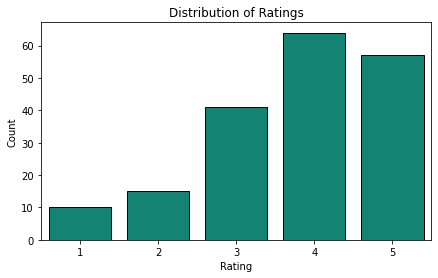

In [43]:
# Distribution of the Ratings
plt.figure(figsize=(7, 4))
sns.countplot(x='rating', data=df, order=sorted(df['rating'].unique()), color=color, edgecolor="black")
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

We clearly see in this plot that the majority of reviews has a positive rating with 3 or more "stars".

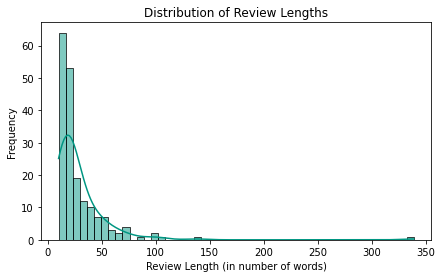

In [44]:
# Distribution of the review lengths
plt.figure(figsize=(7, 4))
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length (in number of words)')
plt.ylabel('Frequency')
plt.show()

In the plot of the review lengths, we can identify that most of the reviews have a length (including title, pros and cons) of around 10 to 20 words. But we can also identify an outlier with around 340 words. We will treat this outlier separatly in order to not distort our further analysis when working with the Review Length. Outliers can significantly affect the visualization and interpretation of the data. A common method to detect outliers is the IQR (interquartile range) method. In the IQR method, any value below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR is considered an outlier, where Q1 and Q3 are the first and third quartiles, respectively, and IQR = Q3 - Q1. When we detected the outlier, we can just remove it from the data set (but just for the review length analyses) because it is only one data point and we won't lose much information when filtering it out.

In [45]:
# Calculate Q1, Q3, and IQR
Q1 = df['review_length'].quantile(0.25)
Q3 = df['review_length'].quantile(0.75)
IQR = Q3 - Q1

# Define the upper and lower bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
df_filtered = df[(df['review_length'] >= lower_bound) & (df['review_length'] <= upper_bound)]

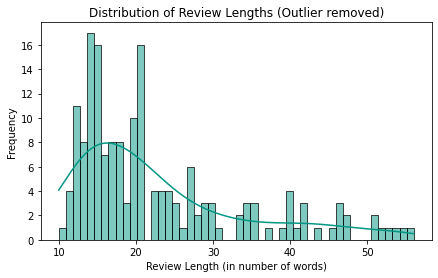

In [46]:
# Show the same plot, distribution of review lengths, but without the outlier
plt.figure(figsize=(7, 4))
sns.histplot(df_filtered['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths (Outlier removed)')
plt.xlabel('Review Length (in number of words)')
plt.ylabel('Frequency')
plt.show()

We can see that removing the outlier enables us to have a much clearer and detailed visualization of the data distributions as the data is not compressed on the x-axis to show to outlier. Now we will also have a look the the text lengths for the title, pros and cons of each review. This can help us understand if there are significant differences in the length of different parts of the reviews, which might suggest different levels of emphasis or attention given by the reviewers.

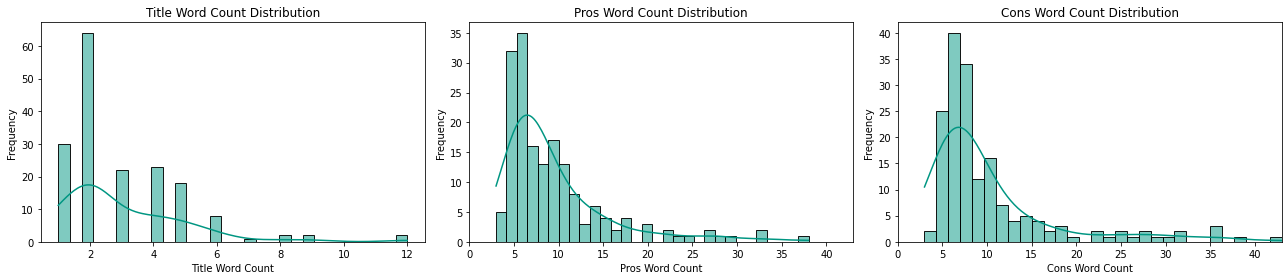

In [47]:
# Create a 1x3 subplot
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Plot title length distribution
sns.histplot(data=df_filtered, x='title_length', bins=30, color=color, ax=axes[0], kde=True)
axes[0].set_title('Title Word Count Distribution')
axes[0].set_xlabel('Title Word Count')
axes[0].set_ylabel('Frequency')

# Plot pros length distribution
sns.histplot(data=df_filtered, x='pros_length', bins=30, color=color, ax=axes[1], kde=True)
axes[1].set_title('Pros Word Count Distribution')
axes[1].set_xlabel('Pros Word Count')
axes[1].set_ylabel('Frequency')

# Plot cons length distribution
sns.histplot(data=df_filtered, x='cons_length', bins=30, color=color, ax=axes[2], kde=True)
axes[2].set_title('Cons Word Count Distribution')
axes[2].set_xlabel('Cons Word Count')
axes[2].set_ylabel('Frequency')

# To make x-axis same for both pros and cons
max_pros_cons = max(df_filtered['pros_length'].max(), df_filtered['cons_length'].max())
axes[1].set_xlim([0, max_pros_cons])
axes[2].set_xlim([0, max_pros_cons])

plt.tight_layout()
plt.show()

We can see that the title mainly contains 2 words, which is not surprising, since a title is usually supposed to be concise. For the word counts of the pros and cons texts, we see that there is not really difference between both distributions, suggesting that the employees in general do not favor one of these text fields over the other.

### Relationship between Rating and text length

In this aspect we want to check whether there is a relationship between the rating of a review and the length of the different review components, following the idea that an employee who is assigning a negativ review might write less positive but more negative text or employees who write longer reviews in general are less satisfied and want to critizise the company. Therefore we can calculate the correlation coefficient, which is a good way to quantify the linear relationship between two variables.

In [48]:
# Check the correlation between 'rating' and the lengths of 'title', 'pros', 'cons'
correlations = df_filtered[['rating', 'review_length', 'title_length', 'pros_length', 'cons_length']].corr()

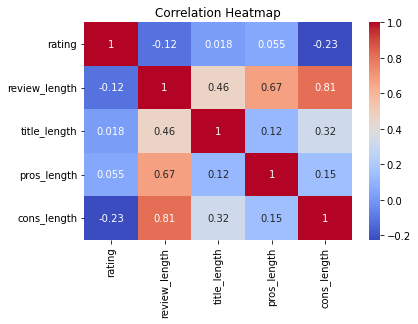

In [49]:
# Visualize these correlations using a heatmap
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

The correlation coefficient ranges from -1 to 1. A value closer to -1 indicates a strong negative correlation, a value closer to 1 indicates a strong positive correlation, and a value closer to 0 indicates no correlation.

Obviously, we see that there is a high correlation between the review length of the whole review (which is just the composition of title, pros and cons) and the length of pros, cons and the title which is self-explanatory. But we are interested in the correlation between the rating and the other variables. Here we see that there exists no linear relationship between the rating and the title and pros length.

However, there is a negative correlation between the rating and the cons length. This can be interpreted as when an employee writes more text for the cons section of the review, the overall rating he gives will be worse, which also aligns with the second part of our hypothesis. But writing more positive text does not lead to a linear increase of the rating. There is also a small negative correlation between the rating and the review length overall, indicating that the more an employee writes the worse the rating, however we have to be careful with this interpretation as this might just reflect the impact of the negative correlation of the cons length and rating as we showed before and we know that the review length as a whole includes the cons section.

In addition, correlation does not imply causation. Even if we find a strong correlation between cons length and rating, it does not necessarily mean that writing more negative text causes lower job satisfaction, it just means that they are associated. There could be other underlying factors causing both to occur.

We can now also show this relationship using a scatterplot where each dot represents a review. The x-coordinate of the dot is the length of the review, and the y-coordinate is the rating. The line in the plot is the best fit linear regression line. If your hypothesis, that people who write more are in general less satisfied, is correct, we should expect to see a negative slope, suggesting that longer reviews tend to have lower ratings. The alpha parameter for the scatter plot is set to 0.3 for better visibility when data points overlap.

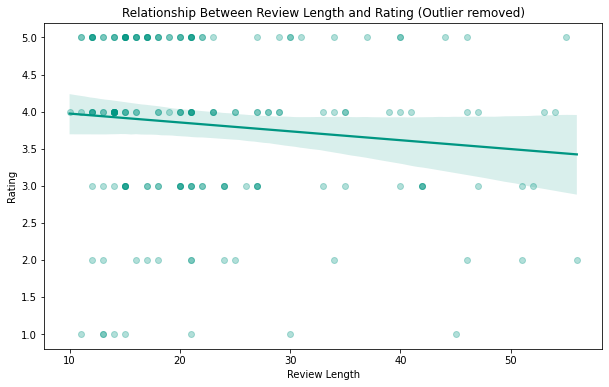

In [50]:
plt.figure(figsize=(10, 6))
sns.regplot(x='review_length', y='rating', data=df_filtered, scatter_kws={'alpha':0.3}, color=color)
plt.title('Relationship Between Review Length and Rating (Outlier removed)')
plt.xlabel('Review Length')
plt.ylabel('Rating')
plt.show()

Now we can also have a closer look at the distribution of the text length compared to the specific ratings using boxplots.

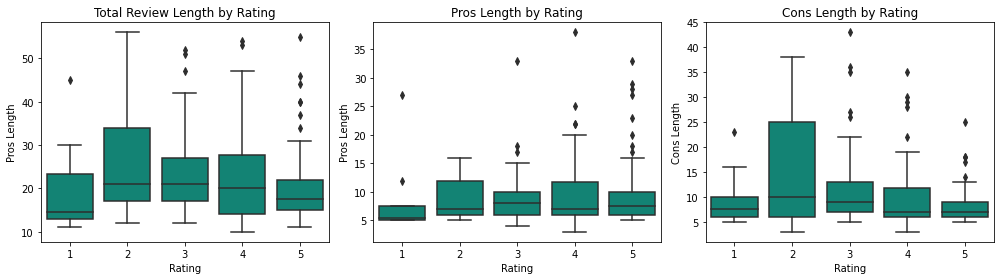

In [51]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))

sns.boxplot(x='rating', y='review_length', data=df_filtered, ax=ax[0], color=color)
ax[0].set_title('Total Review Length by Rating')
ax[0].set_xlabel('Rating')
ax[0].set_ylabel('Pros Length')

sns.boxplot(x='rating', y='pros_length', data=df_filtered, ax=ax[1], color=color)
ax[1].set_title('Pros Length by Rating')
ax[1].set_xlabel('Rating')
ax[1].set_ylabel('Pros Length')

sns.boxplot(x='rating', y='cons_length', data=df_filtered, ax=ax[2], color=color)
ax[2].set_title('Cons Length by Rating')
ax[2].set_xlabel('Rating')
ax[2].set_ylabel('Cons Length')

plt.tight_layout()
plt.show()

Here we can see that it looks like nearly all reviews have the same length independent of the rating. However, there is a slight tendency that negativ reviews with the rating of 1 have less text and reviews with a rating of 2 have more text. This could perhaps be due to the fact that employees who are so dissatisfied that they give a rating of 1 do not want to invest effort in a review, whereas employees who give a rating of 2 may be dissatisfied, but at least still want to criticize the company, perhaps in hope that the company will improve.

If we have a look at the specific length of the positive text, we can see that people tend to write less positive text if they rated the company with 1 which is self-explanatory and for the negative text, we can see that people generally write and slightly less if the review was positive, but they tend to write especially much negative text when they rated the company with a 2.

### Development of Job Ratings over Time

Next we are interested how the job ratings evolved over time and whether we can identify a clear trend.

Firstly, we group the data by date (to the nearest month), and for each month, we calculate the mean of the 'rating' values, thereby yielding the average monthly rating. However, as our dataset may not include reviews for every single month, it's likely that we have some missing values in our time series. 

To address this, we use a method called **interpolation**, which estimates the missing values based on the surrounding data. In this case, we employ 'linear' interpolation, which assumes a straight-line relationship between the points before and after the missing data. To distinguish between our original data and the interpolated data, we plot both on the graph, using distinct colors and marker styles. This gives a clear visual representation of the missing data and how it has been estimated.

As a next step, we fit a **Linear Regression model** to our time series of average monthly ratings. The purpose here is to identify a potential trend in our data over time. We plot the resulting regression line on our graph, providing a visual representation of this trend.

Since a pure consideration of the average ratings may lead to wrong conclusions, because for example there was only one review in a month with a rating of 1 and might be not representative for a whole "bad" month, we also take into account the number of reviews of each month. To visualize this, we plot the number of reviews each month as a bar chart on a secondary y-axis. This allows us to correlate the trends in the average monthly rating with the number of reviews, providing a more comprehensive view of the data.

The graph, thus, offers an intuitive way to understand how the reviews and ratings have evolved over time, helping to identify any temporal patterns or trends that might be present in our data

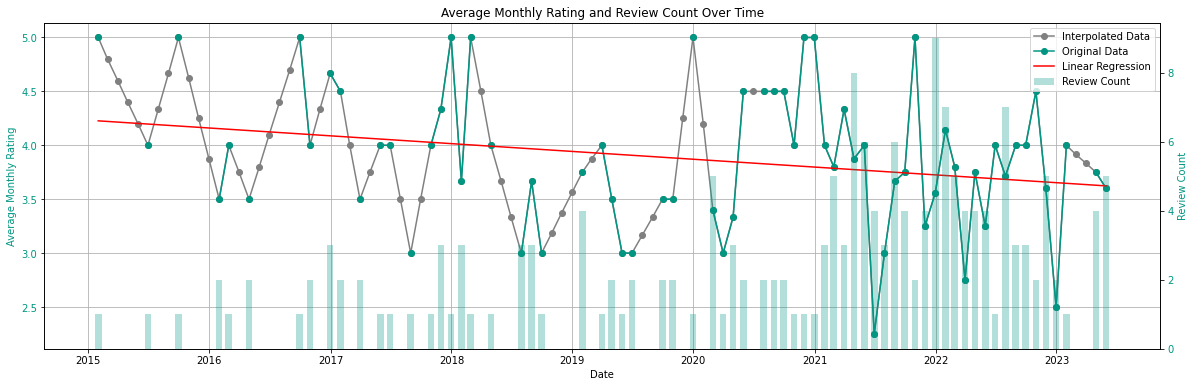

In [52]:
# Group by date (to the month) and calculate the average rating
average_ratings_monthly = df.groupby(pd.Grouper(key='date', freq='M'))['rating'].mean()

# Count the number of reviews per month
review_counts_monthly = df.groupby(pd.Grouper(key='date', freq='M')).size()

# Create a copy of original data before interpolation
average_ratings_monthly_before_interpolation = average_ratings_monthly.copy()

# Interpolate missing values
average_ratings_monthly.interpolate(method='linear', inplace=True)

# Define marker style and color for original and interpolated data
marker_style = dict(linestyle='-', marker='o', markersize=6)
original_marker_color = '#009682'
interpolated_marker_color = 'gray'

# Create a figure and a single axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot the interpolated data
ax1.plot(average_ratings_monthly.index, average_ratings_monthly.values,
         color=interpolated_marker_color, 
         label='Interpolated Data',
         **marker_style)

# Overlay the original data
ax1.plot(average_ratings_monthly_before_interpolation.index, 
         average_ratings_monthly_before_interpolation.values,
         color=original_marker_color, 
         label='Original Data',
         **marker_style)

# Fit a Linear Regression model
X = mdates.date2num(average_ratings_monthly.index.to_pydatetime()).reshape(-1, 1)  # Convert dates to numerical format for regression
y = average_ratings_monthly.values
model = LinearRegression()
model.fit(X, y)

# Generate predicted ratings
y_pred = model.predict(X)

# Plot the regression line
ax1.plot(average_ratings_monthly.index, y_pred, color='red', label='Linear Regression') 

ax1.set_xlabel('Date')
ax1.set_ylabel('Average Monthly Rating', color=original_marker_color)
ax1.tick_params(axis='y', labelcolor=original_marker_color)
ax1.grid(True)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()
ax2.bar(review_counts_monthly.index, review_counts_monthly.values, 
        width=20, align='center', color=color, alpha=0.3, label='Review Count')
ax2.set_ylabel('Review Count', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Adding legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

plt.title('Average Monthly Rating and Review Count Over Time')
plt.savefig('plots/monthly_rating_over_time.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

The red line in the plot shows the trend line from the linear regression, so we can see a slight negative trend of the review ratings. However, the result is not really reliable, as we only have few data and we would have to validate this using more data. We also see that in the years of 2015 till 2021 only there have bene significantly less reviews submitted than from 2021 on, which may be due to the increasing presence of the job platform as well as general digitization.

### Further Temporal Trend Analysis

Next we want to check whether the rating might depend on other time related information like the month or the weekday. Since the rating is a ordinal feature, we will use barplots for this.

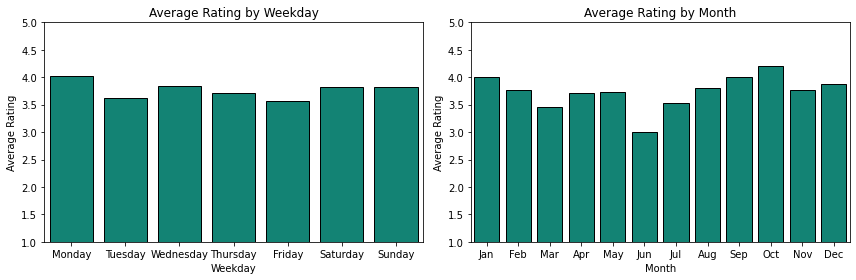

In [53]:
# Extract month and weekday from date and map them to their names
df['month'] = df['date'].dt.month.apply(lambda x: calendar.month_abbr[x])
df['weekday'] = df['date'].dt.weekday.apply(lambda x: calendar.day_name[x])

# Define the order of months and weekdays
month_order = [calendar.month_abbr[i] for i in range(1, 13)]
weekday_order = [calendar.day_name[i] for i in range(7)]

# Create a 1x2 subplot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plotting average rating by weekday
sns.barplot(x='weekday', y='rating', data=df, ci=None, ax=axes[0], color=color, edgecolor="black", order=weekday_order)
axes[0].set_title('Average Rating by Weekday')
axes[0].set_xlabel('Weekday')
axes[0].set_ylabel('Average Rating')
axes[0].set_ylim(1, 5)  # To set y-axis limits for better comparison

# Plotting average rating by month
sns.barplot(x='month', y='rating', data=df, ci=None, ax=axes[1], color=color, edgecolor="black", order=month_order)
axes[1].set_title('Average Rating by Month')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Average Rating')
axes[1].set_ylim(1, 5)  # To set y-axis limits for better comparison

plt.tight_layout()
plt.show()

We see that there is not really a temporal dependence on neither the weekdays nor the months. Only exception might be June, where the average rating dropped a bit lower than the other months. This however, might not be really respresentative, as there might be just less reviews in this month and therefore not giving this any statistical relevance. But verify this, we plot the amount of posted reviews over the above time features.

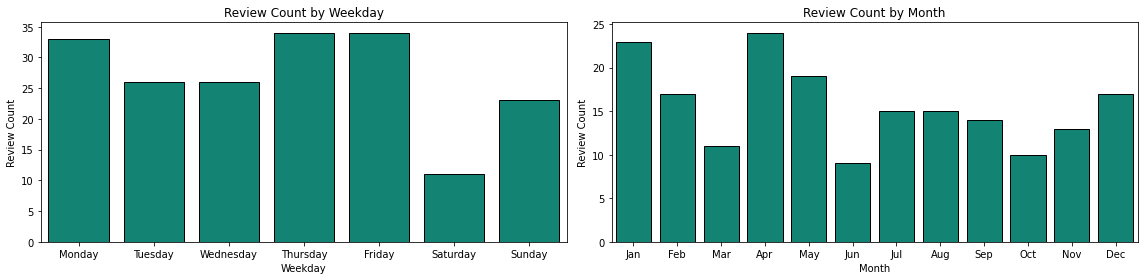

In [54]:
# Group by 'weekday' and 'month' and count the reviews
reviews_per_weekday = df.groupby('weekday').size().reset_index(name='review_count')
reviews_per_month = df.groupby('month').size().reset_index(name='review_count')

# Define the order of months and weekdays
weekday_order = [calendar.day_name[i] for i in range(7)]
month_order = [calendar.month_abbr[i] for i in range(1, 13)]

# Create a 1x2 subplot
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Plotting review count by weekday
sns.barplot(x='weekday', y='review_count', data=reviews_per_weekday, ax=axes[0], color=color, edgecolor="black", order=weekday_order)
axes[0].set_title('Review Count by Weekday')
axes[0].set_xlabel('Weekday')
axes[0].set_ylabel('Review Count')

# Plotting review count by month
sns.barplot(x='month', y='review_count', data=reviews_per_month, ax=axes[1], color=color, edgecolor="black", order=month_order)
axes[1].set_title('Review Count by Month')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Review Count')

plt.tight_layout()
plt.show()

As we already assumed, the average number of reviews is significantly lower in June compared to some other months, so there might be no real relationship between the rating a specific month. However, we can see that on Saturedays employees tend to be writing less reviews and on average the most reviews are written in Januare and April.

## 4. Job Clustering and Analysis

We noticed in our exploratory data analysis that we have an extremely high number of different jobs, especially in comparison to our overall amount of reviews. However, this is due to the fact that the field is a free text field, which is why some employees have included spelling mistakes or have different designations for actually the same job, such as "Werkstudent", "Werkstudentin", "Werkstudent Data Science", "Masterand" and "Bachelorand" actually all belong to the category "Studierende". Because we have a mixture of job titles in different languages and formats, clustering those jobs is an extremly difficult task. We will therefore use a rule-based classification and manual grouping based on keywords. Then we will try to uncover relationships between an employee's job category and the rating to find out whether there exist some jobs with greater dissatisfaction than others.

In [55]:
# Show different job titles
df['job'].head(15)

0     Chemikant und Anlagenfahrer
1               Anlagenmechaniker
2             Industriemechaniker
3                     Werkstudent
4                       Ingenieur
5       Finance Senior Specialist
6          Senior DevOps Engineer
7                     Werkstudent
8                   HR Generalist
9                 Laborteamleiter
10                     Praktikant
11           Freight Cost Manager
12      Kaufmännische Angestellte
13                       Director
14                 Digital Expert
Name: job, dtype: object

In [70]:
def job_category(job):
    # Define your rules for each category
    rules = {
        "Mechaniker": ["mechaniker", "fahrer", "operator", "techniker"],
        "Research": ["research", "forschung"],
        "Studierende": ["student", "praktikant", "intern", "trainee", "bachelor", "master", "praktikum"],
        "Ingenieur": ["ingenieur", "engineer", "ingénieur"],
        "Finance": ["accountant", "controller", "finance", "buchhalter", "steuer"],
        "Human Resources": ["recruiter", "hr", "human", "personnel", "payroll"],
        "Management": ["manager", "director", "leitung", "chief", "head", "lead", "officer", "management"],
        "Chemiker": ["lab", "chemie", "chemi", "labor"],
        "IT": ["it", "data", "digital", "sap", "software", "web", "online", "transformation"],
        "Consultant": ["consultant", "berater"],
        "Marketing": ["marketing", "product", "kommunikation"],
        "Sales": ["sales", "verkauf", "vertrieb"],
        "Recht": ["patent", "recht", "jura", "jurist", "attorney", "legal"],
        "Others": []
    }

    job = job.lower()
    for key, values in rules.items():
        if any(value in job for value in values):
            return key
    return "Others"

In [72]:
# Investigate the clustering manually
#pd.set_option('display.max_rows', None) # option to view all rows

df['job_category'] = df['job'].apply(job_category)
df[['job', 'job_category']].head(15)

,job,job_category
0,Chemikant und Anlagenfahrer,Mechaniker
1,Anlagenmechaniker,Mechaniker
2,Industriemechaniker,Mechaniker
3,Werkstudent,Studierende
4,Ingenieur,Ingenieur
5,Finance Senior Specialist,Finance
6,Senior DevOps Engineer,Ingenieur
7,Werkstudent,Studierende
8,HR Generalist,Human Resources
9,Laborteamleiter,Chemiker


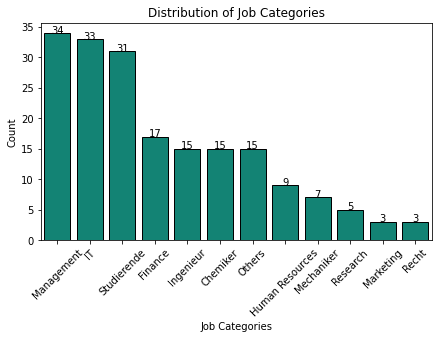

In [74]:
# Count the occurrence of each job category
category_counts = df['job_category'].value_counts()

# Plot the counts as a bar chart
plt.figure(figsize=(7, 4))
barplot = sns.barplot(x=category_counts.index, y=category_counts.values, color=color, edgecolor="black")

plt.title('Distribution of Job Categories')
plt.xlabel('Job Categories')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Add the count on top of each bar
for i, count in enumerate(category_counts.values):
    barplot.text(i, count, count, ha='center')

plt.show()

Looking at the distribution of reviews across job categories, we see that employees from the 'Management' category have contributed the most reviews, followed closely by 'IT' and 'Studierende'. This is interesting and could suggest that people in managerial positions and IT roles are more likely to submit reviews, or simply that there are more employees in these categories at the company.

It's also noteworthy that 'Studierende' ranks high in the number of reviews, which could be attributed to internships or work-study programs, and indicates a high level of engagement among this group.

On the lower end of the scale, 'Marketing', 'Recht', 'Research', 'Human Resources' and 'Mechaniker' have the fewest reviews, which could suggest smaller team sizes in those departments, or perhaps less inclination among these employees to leave reviews.

Meanwhile, 'Finance', 'Chemiker', and 'Ingenieur' fall in the middle, contributing a moderate number of reviews.

In general, this distribution provides us with useful insights into the participation of different job categories in the review process, which can be helpful for understanding the company's employee dynamics and their engagement with feedback mechanisms. However, without additional context or data, these interpretations should be taken as hypotheses rather than definitive conclusions.

### Relationship between Job Category and Rating

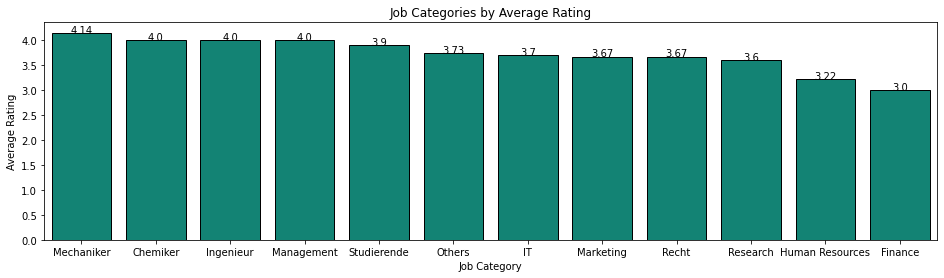

In [75]:
# Calculate the mean rating for each job category
category_mean_ratings = df.groupby('job_category')['rating'].mean().sort_values(ascending=False)

# Create a bar plot
plt.figure(figsize=(16,4)) # Specify the figure size
bars = sns.barplot(x=category_mean_ratings.index, y=category_mean_ratings.values, color=color, edgecolor="black")
# Label the axes and the chart
plt.xlabel('Job Category')
plt.ylabel('Average Rating')
plt.title('Job Categories by Average Rating')

# Add the count on top of each bar
for i, count in enumerate(category_mean_ratings.values):
    bars.text(i, count, round(count, 2), ha='center')

plt.show()

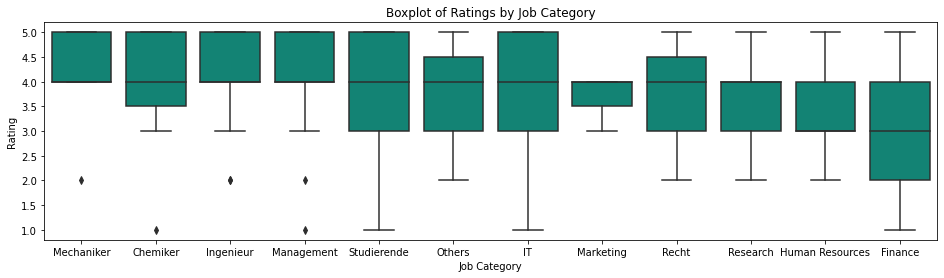

In [76]:
# Calculate the mean rating for each job category and get the sorted index
sorted_categories = df.groupby('job_category')['rating'].mean().sort_values(ascending=False).index

# Create box plots for each job category
plt.figure(figsize=(16,4))
sns.boxplot(x='job_category', y='rating', data=df, order=sorted_categories, color=color)
plt.xlabel('Job Category')
plt.ylabel('Rating')
plt.title('Boxplot of Ratings by Job Category')
plt.show()

Looking at the average ratings across job categories, we find some interesting patterns. The 'Mechaniker' category has the highest average rating, suggesting that employees in mechanic roles are generally the most satisfied with their jobs. This is particularly interesting considering this category is one of the less represented in terms of review count, pointing out that despite their smaller numbers, their job satisfaction seems to be high.

The 'Management' category, which had the highest review count, also has a relatively high average rating, indicating a generally positive perception of their role in the company. This is significant as it suggests a positive work environment from the perspective of managerial positions.

'Ingenieur', 'Studierende', and 'Chemiker' categories all have average ratings around 4, which is quite positive. Although 'Studierende' ranks high in the number of reviews, their satisfaction level is not the highest, which might hint towards areas for improvement in the work-study programs or intern roles.

Interestingly, the 'IT' category, despite being the second most represented in terms of review count, has a below-average rating. This could suggest some dissatisfaction among employees in this area, possibly due to workload, job demands, or work environment, and could warrant further investigation.

The 'Finance' category has the lowest average rating. Although it's not the least represented in terms of review count, this low satisfaction level could indicate potential issues that need addressing in the finance department.

'Human Resources' also shows a lower average rating, which could be of concern considering the important role of HR in employee satisfaction and company culture. This might be a signal for the organization to pay more attention to the working conditions within this department.

In conclusion, these results highlight the importance of considering both the number of reviews and the average rating for each job category. While the quantity of reviews can give us insights into the level of engagement or the size of certain departments, the average rating helps us to understand job satisfaction and potential areas for improvement within these categories

## 5. TF-IDF and Word Clouds 

As already explained in our Text Normalization Step at the beginning, TF-IDF (Term Frequency-Inverse Document Frequency) is a numerical statistic used to reflect how important a word is to a document in a collection or corpus. The tf-idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.

**TF (Term Frequency)** is the number of times a word appears in a document, divided by the total number of words in that document.  
**IDF (Inverse Document Frequency)** is the log of the number of documents divided by the number of documents that contain the word. In other words, it reduces the weight of words that occur very often in the dataset and increases the weight of words that occur rarely.

We will use TF-IDF to show the most important words of the 'pros' and 'cons'.

In [77]:
# Function to calculate TF-IDF and generate word cloud
def generate_word_cloud_and_top_tfidf(df, column, top_n=10):
    # Define the TF-IDF vectorizer that will be used to process the data
    tfidf = TfidfVectorizer(sublinear_tf=True, min_df=2, stop_words=stop_words) #, max_df=0.9

    # Apply this vectorizer to the column of the dataset
    features = tfidf.fit_transform(df[column].values.astype('U'))

    # Get the names of the features
    feature_names = tfidf.get_feature_names_out()

    # Get the scores of each feature in each review
    scores = features.toarray()

    # Initialize dictionaries to store the total scores for each word
    total_scores = {word: 0 for word in feature_names}

    # Add up the scores for each word
    for i in range(len(feature_names)):
        total_scores[feature_names[i]] += sum(scores[:, i])

    # Sort the total scores dictionary by score and get the top N terms
    sorted_scores = sorted(total_scores.items(), key=lambda x: x[1], reverse=True)
    top_terms = sorted_scores[:top_n]

    # Print the top N terms and their scores
    print(f"Top {top_n} terms in {column} column and their TF-IDF scores:")
    for term, score in top_terms:
        print(f"{term}: {score}")

    # Initialize a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color ='white')

    # Generate the word cloud
    wordcloud.generate_from_frequencies(total_scores)

    # Display the generated image:
    plt.figure(figsize=(10, 8), facecolor=None)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

### Most important words in "Pros"

Top 10 terms in processed_pros column and their TF-IDF scores:
gut: 21.006900429492323
kollege: 11.856636582167697
gehalt: 9.200337940168968
nett: 7.401821910989336
mitarbeiter: 6.663095829351942
vieler: 6.267254333478435
aufgabe: 6.21850412923681
unternehmen: 6.1226148797933755
arbeiten: 5.783439098312856
sicher: 5.479671967398675


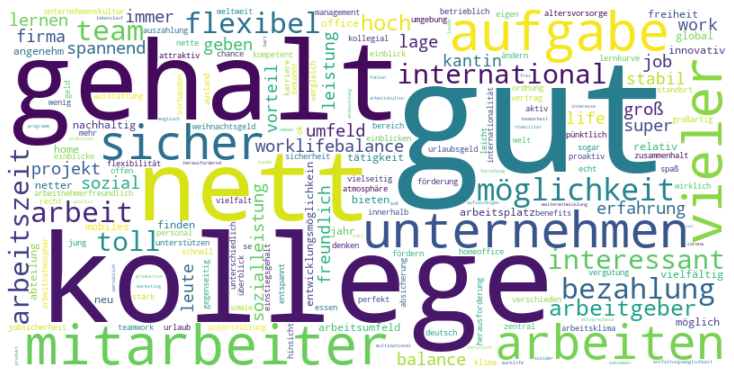

In [78]:
# Generate word clouds and print top TF-IDF terms for 'pros' column
generate_word_cloud_and_top_tfidf(df, 'processed_pros')

### Most important words in "Cons"

Top 10 terms in processed_cons column and their TF-IDF scores:
gehalt: 9.83660581489253
wenig: 7.315627876477377
vieler: 7.1206139673294295
mitarbeiter: 6.606635437256849
langsam: 6.014868131191405
hoch: 5.958086767566144
gut: 5.711752136053019
schlecht: 5.2314451506133794
geben: 5.113019652572612
manchmal: 4.611169530887126


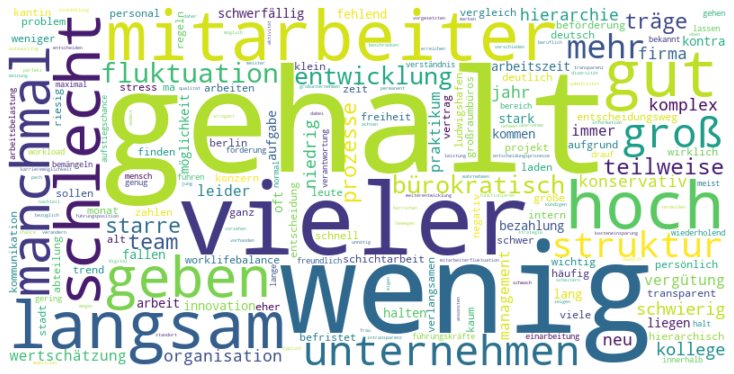

In [79]:
# Generate word clouds and print top TF-IDF terms for 'cons' column
generate_word_cloud_and_top_tfidf(df, 'processed_cons')

### Capture Context using Bigrams

As mentioned in the chapter on preprocessing, these unigrams lack context and are therefore sometimes difficult to interpret. Even though it is obvious that the word "gehalt", when it appears in the "cons" column, is considered too low or inappropriate, other words like "hoch", "langsam" or "vieler" (especially adjectives) need a pair of words to elicit relevant information from the word. Therefore we also investigate the bigrams.

In [80]:
def get_top_n_bigrams(corpus, n=None, min_df=1):
    vec = TfidfVectorizer(ngram_range=(2, 2), stop_words=stop_words, min_df=min_df).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [81]:
top_pros_bigrams = get_top_n_bigrams(df['processed_pros'], n=15, min_df=2)
top_cons_bigrams = get_top_n_bigrams(df['processed_cons'], n=15, min_df=2)

print("Pros:")
for bigram, freq in top_pros_bigrams:
    print(f"{bigram}: {freq}")
    
print("\nCons:")
for bigram, freq in top_cons_bigrams:
    print(f"{bigram}: {freq}")

Pros:
gut gehalt: 6.416436867534689
nett kollege: 5.794523724800252
flexibel arbeitszeit: 5.072578229288743
gut bezahlung: 4.575012268165521
vieler möglichkeit: 3.9064307836495082
sicher arbeitsplatz: 3.743877684864231
home office: 3.703589723147927
work life: 3.661788759250334
life balance: 3.661788759250334
gehalt gut: 3.6307585576346115
gut worklifebalance: 3.534719957022164
aufgabe gut: 3.4521322484722834
gut sozialleistung: 3.3055888931354356
mobiles arbeiten: 3.0894109841037083
gut kollege: 2.816122356924796

Cons:
hoch fluktuation: 3.6902663415834827
starre struktur: 3.3384020132624457
gehalt hoch: 3.0
groß unternehmen: 3.0
gehalt gut: 3.0
aufgrund größe: 2.6864554166313392
schlecht bezahlung: 2.4100107895482674
komplex organisation: 2.3729108332626785
neu aufgabe: 2.0
konservativ struktur: 2.0
fehlend wertschätzung: 2.0
gehalt wenig: 2.0
groß träge: 2.0
langsam prozesse: 2.0
gehalt niedrig: 2.0


In [82]:
def generate_wordcloud_from_bigrams(bigrams, title):
    # Convert bigram tuples to a single string with words joined by an underscore
    bigrams_as_strings = ['_'.join(bigram[0].split(' ')) for bigram in bigrams]
    
    # Create a string where each bigram is repeated according to its frequency
    bigrams_with_frequency = ' '.join(bigrams_as_strings)
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(bigrams_with_frequency)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=24)  # Add title
    plt.axis("off")
    plt.show()

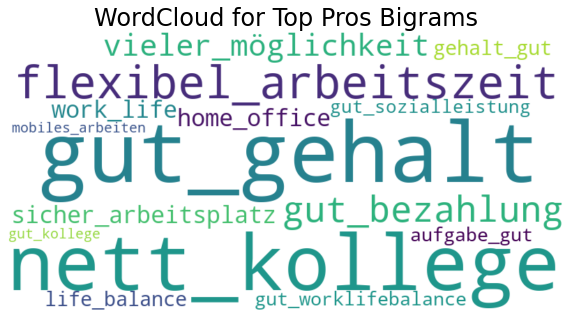

In [83]:
# Generate word clouds for top pros bigrams
generate_wordcloud_from_bigrams(top_pros_bigrams, 'WordCloud for Top Pros Bigrams')

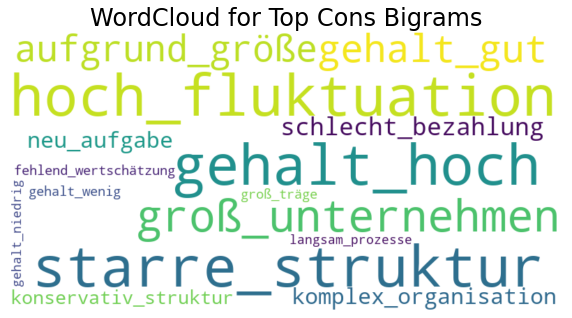

In [84]:
generate_wordcloud_from_bigrams(top_cons_bigrams, 'WordCloud for Top Cons Bigrams')

Those word clouds provide us with some concise insights about what seems to be most important in terms of positive and negative aspects. We also see that the context is now much clearer when looking at the bigrams. Based on this simple analysis, we have already been able to identify now some paint points that cause dissatisfaction for employees and these topics could now be followed up by specific actions for improvement (we will also provide some ideas using Generative AI later on).

## 6. Lasso Regression: Determine which terms in the job reviews drive the rating

This part goes in a similar direction as our previous chapter, because we now want to determine which terms in our data drive the rating of the job reviews or in other words: why is a certain rating assigned. Lasso Regression is a popular choice for this kind of problem due to its inherent ability to perform feature selection. By including a penalty for the number of features used in the model, Lasso Regression can help identify the most significant terms in predicting the job review ratings.

### Unigram Analysis

In our analysis, we first apply Lasso regression on unigrams. Lasso regression is a type of linear regression that uses shrinkage, where data values are shrunk towards a central point, like the mean. The main advantage of Lasso regression is its ability to perform feature selection by reducing the coefficients of unimportant features to zero, making it a very useful tool for this project where we are trying to find which terms in the review text are most predictive of the review ratings.

The hyperparameter of the Lasso model, alpha, controls the amount of shrinkage: the larger the value of alpha, the greater the amount of shrinkage and thus the more coefficients are reduced to zero. We optimize the value of alpha by using cross-validation, specifically LassoCV, which automatically performs cross-validation on a range of alpha values to find the optimal one.

In [85]:
# Let's start with the unigram term-document matrix
X_unigram = unigram_tfidf_df.values

# Create a LassoCV object
lasso_cv = LassoCV(cv=10, random_state=42)

# Fit the Lasso model on the entire dataset
lasso_cv.fit(X_unigram, df['rating'])

# Print the optimal alpha value
print("Optimal alpha value: ", lasso_cv.alpha_)

# Get the feature names and coefficients into a DataFrame
feature_coeffs_cv = pd.DataFrame({
    'Feature': unigram_tfidf_vectorizer.get_feature_names_out(),
    'Coefficient': lasso_cv.coef_
})

Optimal alpha value:  0.009248769992359235


Now we take a look at the largest and smallest 10 coefficients of the lasso regressions, as those words drive the regression and therefore the rating.

In [86]:
# Display the top 10 features with the highest coefficients
print(feature_coeffs_cv.sort_values(by='Coefficient', ascending=False).head(10))

         Feature  Coefficient
376          top     1.086658
166          gut     0.831914
375         toll     0.632885
365        super     0.453983
16   arbeitgeber     0.334901
27   arbeitszeit     0.158973
254     manchmal     0.046630
0             ab    -0.000000
309        prima     0.000000
308    praktisch     0.000000


In [87]:
# Display the top 10 features with the lowest coefficients
print(feature_coeffs_cv.sort_values(by='Coefficient').head(10))

       Feature  Coefficient
332   schlecht    -2.675737
151     gehalt    -1.333437
244      leute    -1.146990
112  erfahrung    -0.774846
431      wenig    -0.321025
439   wirklich    -0.263992
209      klein    -0.176680
202        job    -0.151137
238     leicht    -0.114262
229       lage    -0.038916


This approach, using cross-validation to find the optimal alpha value, is generally more robust and helps prevent overfitting the model to the data. The selected features via this method are the ones that the model finds most indicative of the review rating, based on the data.

The terms that have the most positive effect on the rating are 'top', 'gut', 'arbeitzeit', 'super', and 'toll'. This makes intuitive sense, as these words are generally associated with positive experiences and feelings. So if a review contains one of these words, it's likely that the rating is good.

On the other hand, the terms that have the most negative effect on the rating are 'schlecht', 'gehalt', 'leute', 'erfahrung', 'leicht' (might imply lack of challenge). These terms might be associated with elements of the job that employees are dissatisfied with.

We should note that Lasso regression assumes a linear relationship between the predictors (terms) and the target variable (rating). If these assumptions do not hold, the results may not accurately reflect the relationships in the data. Also, the terms are interpreted in the context of the presence of other terms in the model. Therefore, while a term might be strongly predictive in the current model, its predictive power might change if the model were retrained with a different set of terms.

### Bigram Analysis
Next, we apply a similar analysis to bigrams (two-word phrases) in the review text.

In [88]:
# Let's start with the bigram term-document matrix
X_bigram = bigram_tfidf_df.values

# Create a LassoCV object
lasso_cv_bigrams = LassoCV(cv=10, random_state=42, max_iter=5000)

# Fit the Lasso model on the entire dataset
lasso_cv_bigrams.fit(X_bigram, df['rating'])

# Print the optimal alpha value
print("Optimal alpha value: ", lasso_cv_bigrams.alpha_)

# Get the feature names and coefficients into a DataFrame
feature_coeffs_cv_bigrams = pd.DataFrame({
    'Feature': bigram_tfidf_vectorizer.get_feature_names_out(),
    'Coefficient': lasso_cv_bigrams.coef_
})

Optimal alpha value:  0.010026144444063887


In [89]:
# Display the top 10 features with the highest coefficients
print(feature_coeffs_cv_bigrams.sort_values(by='Coefficient', ascending=False).head(10))

               Feature  Coefficient
33     gut arbeitgeber     0.567424
99    toll arbeitgeber     0.438212
34       gut bezahlung     0.155760
56  interessant arbeit     0.129903
31    groß unternehmen     0.110840
37          gut gehalt     0.107813
74    mobiles arbeiten    -0.000000
83     persönlich ziel    -0.000000
82         neu aufgabe     0.000000
81      netter kollege     0.000000


In [90]:
# Display the top 10 features with the lowest coefficients
print(feature_coeffs_cv_bigrams.sort_values(by='Coefficient').head(10))

                  Feature  Coefficient
88    sicher arbeitsplatz    -0.825186
14  fehlend wertschätzung    -0.689215
89             sicher job    -0.671871
57    interessant aufgabe    -0.587544
22             gehalt gut    -0.533338
84     schlecht bezahlung    -0.464026
53            home office    -0.106353
76           nett kollege    -0.078636
83        persönlich ziel    -0.000000
82            neu aufgabe     0.000000


The positive coefficients represent the terms (in this case, bigrams) that are associated with higher ratings. For example, 'gut arbeitgeber' and 'toll arbeitgeber' have the highest positive coefficients, suggesting that when these terms are present in a review, the review is likely to have a higher rating. Other terms like 'groß unternehmen', 'interessant arbeit' and 'gut bezahlung' are also positively associated with the rating.

On the other hand, the negative coefficients represent the terms that are associated with lower ratings. The terms 'sicher arbeitsplatz', 'fehlend wertschätzung' , 'interessant aufgabe', and 'schlecht bezahlung' have the highest negative coefficients. This suggests that when these terms appear in a review, they are likely to be associated with a lower rating. 

However, this is counterintuitive as we would associate some of those features with a positive rating like 'interessant aufgabe'. This might be due to the fact that we analyzed the reviews as a whole, which means the combination of title, pros and cons column. Employees are supposed to fill in all of those text fields when writing a review, so even if a review is negative, the employee might have written something positive for the 'pros' text field which is the reason for those features to appear here. Furthermore, we can interpret those supposedly positive terms to mean that someone who writes a bad review often chooses some meaningless, general or neutral words to fill in the positive aspects of his review. Therefore, if a review contains allegedly positive terms like 'nett kollege' this might indicate that the review does not really have much positive to mention. 

It's also worth mentioning that a terms with a coefficient of zero indicates that this term is not contributing to the prediction of the rating. These are the terms that the Lasso regression has essentially deemed irrelevant for predicting the review rating.

This approach gives us more control over the complexity of the model and allows us to retain more features for interpretability. However, it's important to keep in mind that this might make the model more susceptible to overfitting, and the features selected might not generalize as well to new, unseen data.

In comparison with our previous word cloud approach, the idea of lasso regression tried to find a specific relationship between the words and the ratings whereas the word clouds were just based on the simple tf-idf technique that considered only the word frequency. It was helpful to see what words seemed to be important for the 'pros' and 'cons' column, but knowing the word importance did not tell us anything about what rating arises from it and the tf-idf approach alone was therefore not able to establish a relationship between the rating and the words. But with the lasso regression we were able to come up with such a relation, even though it might be sometimes hard to interpret.

## 7. Topic Modeling

To identify major concerns employees have when writing a negative review, we use topic modeling. 

Topic modeling is a type of statistical modeling for discovering the abstract 'topics' that occur in a collection of documents. In essence, it is an unsupervised machine learning technique used to categorize large volumes of text data into a predefined number of topics. These topics represent a set of words that are representative of the main theme within the collection.

For our project, topic modeling is immensely useful as it can help us identify the major themes and concerns present in the employee reviews. Given that our dataset contains free-text 'pros' and 'cons' fields, the themes identified through topic modeling can help us understand what areas employees frequently mention as positive or negative. This information, in turn, can be valuable for BASF to understand areas of strength and improvement, and can guide interventions to enhance employee satisfaction.

For that, we first filter our data to only negative reviews and focus on the "cons" as this text contains the negative aspects of the review. We define a negative review as a review with a rating of 3 or lower.

In [101]:
# Filter reviews
df_negative = df[df['rating'] <= 2]

# Prepare the text data
data = df_negative['cons'].values.tolist()

# Preprocess the data
processed_data = [preprocess_text(doc).split() for doc in data]

# Create a dictionary and corpus required for LDA
id2word = corpora.Dictionary(processed_data)
texts = processed_data
corpus = [id2word.doc2bow(text) for text in texts]

We are now ready to perform a topic modeling on our filtered data. One popular algorithm for this is **Latent Dirichlet Allocation (LDA)**. In Python, we can use the gensim library for this. Latent Dirichlet Allocation (LDA) is a generative statistical model widely used in Natural Language Processing (NLP) to extract hidden topics from large volumes of text data. The term 'Latent' signifies hidden topics that the model will learn, 'Dirichlet' is a type of probability distribution that the model uses, and 'Allocation' refers to the assignment of topics to the documents.

LDA is based on two fundamental assumptions:

1. Documents are probability distributions over latent topics: This means that each document can be represented as a mixture of a certain number of topics.

2. Topics are probability distributions over words: This means that each topic is characterized by a distribution of words.

In simple terms, if we have a collection of documents (corpus), LDA assumes that these documents were generated in the following way:

- For each document, choose a distribution over topics.
- For each word in the document, choose a topic from the distribution over topics, and then choose a word from that topic's distribution over words.
- When given a corpus of documents, LDA infers the original distributions over topics and words that most likely generated the documents.

One of the key parameters in an LDA model is the number of topics. However, there's no easy way to decide the 'correct' number of topics. Here, we determine the optimal number of topics using a metric called the Coherence Score.

The **Coherence Score** is a measure of the quality of the learned topics. It calculates the similarity between high scoring words within each topic, which gives a sense of how interpretable and meaningful a topic is. The assumption here is that more similar words form a topic that is more interpretable and thus of higher quality.

In our process, we build several LDA models with a different number of topics and compare their Coherence Scores. We choose a range of potential topic quantities, each time building a new model and calculating its coherence. By plotting these coherence scores against the number of topics, we can visually inspect where the increase in coherence score slows down (a point of diminishing returns), which suggests the optimal number of topics, which is in this case 4.

In [102]:
# Use coherence score to determine optimal number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

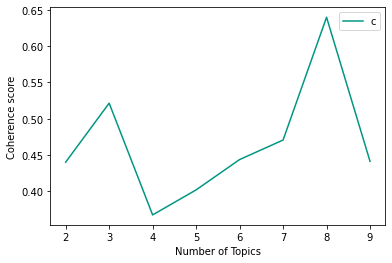

Wall time: 12.8 s


In [103]:
%%time
# Use this function to determine the optimal number of topics
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=10, step=1)
# Plot coherence values to visualize the optimal number of topics
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [104]:
# Select the model with highest coherence value
optimal_model = model_list[coherence_values.index(max(coherence_values))]
# Now, let's print the most probable words for each topic
for idx, topic in optimal_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.032*"hoch" + 0.017*"Gehalt" + 0.017*"Sparwahn" + 0.017*"Unternehmensstrategie" + 0.017*"fallen" + 0.017*"Aktivität" + 0.017*"Svp" + 0.017*"Strategiefolien" + 0.017*"mehr" + 0.017*"Permanent"
Topic: 1 
Words: 0.026*"Mitarbeiter" + 0.026*"führungsposition" + 0.021*"schlecht" + 0.021*"Struktur" + 0.021*"Unternehmen" + 0.021*"alt" + 0.021*"konservativ" + 0.021*"hierarchisch" + 0.021*"Greenwashing" + 0.021*"kaum"
Topic: 2 
Words: 0.036*"halten" + 0.019*"Führungskraft" + 0.019*"inkompetent" + 0.019*"persönlich" + 0.019*"unpassend" + 0.019*"Unterforderung" + 0.019*"toll" + 0.019*"Entwicklung" + 0.019*"Aussicht" + 0.019*"arrogant"
Topic: 3 
Words: 0.024*"möchten" + 0.024*"Hierarchie" + 0.024*"stark" + 0.013*"Gehalt" + 0.013*"vieler" + 0.013*"ideal" + 0.013*"perfekt" + 0.013*"steil" + 0.013*"einbringen" + 0.013*"Arbeitsplatz"
Topic: 4 
Words: 0.023*"obwohl" + 0.021*"Gehalt" + 0.021*"angekündigt" + 0.021*"Sparmaßnahme" + 0.021*"entwickmungsmöglichkeit" + 0.017*"entwicklungsmög

In [105]:
# Inspect an alternative model using only 3 topics
alternative_model = model_list[1]

for idx, topic in alternative_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.011*"zeigen" + 0.011*"Mitarbeiter" + 0.009*"persönlich" + 0.009*"Abteilungsleitung" + 0.009*"Belang" + 0.009*"Verständnis" + 0.009*"null" + 0.009*"fima" + 0.009*"Vertrauensarbeitszeit" + 0.009*"Verarsche"
Topic: 1 
Words: 0.023*"Gehalt" + 0.020*"Mitarbeiter" + 0.018*"schlecht" + 0.015*"hoch" + 0.012*"Vertrag" + 0.012*"Unternehmen" + 0.011*"Management" + 0.011*"vieler" + 0.011*"führungsposition" + 0.010*"vermeiden"
Topic: 2 
Words: 0.019*"schlecht" + 0.014*"Gehalt" + 0.014*"Worklifebalance" + 0.013*"halten" + 0.013*"vieler" + 0.011*"Mitarbeiter" + 0.010*"Struktur" + 0.010*"Hierarchie" + 0.010*"stark" + 0.009*"klein"


The numbers before the words represent the weights (probabilities) of those words within each topic. These weights represent how important a keyword is to that topic. We can now either choose the 8-topic model which has the highest coherence score and provides a detailed perspective, while the 3-topic model (with the 2nd highest coherence score) simplifies the topics and may be easier to interpret.

A possible interpretation of our results and suggested topic titles are:

1. **Topic 1 - "Kostensenkungen und hohe Gehälter"**: This topic seems to capture sentiments about high salaries and the implementation of cost-cutting measures as a part of company strategy, suggesting dissatisfaction with wage disparity.

2. **Topic 2 - "Hierarchische und konservative Unternehmenskultur"**: The discussion here focuses on poor treatment of employees within a hierarchical and conservative company structure, indicating employees feel restricted or stifled.

3. **Topic 3 - "Inkompetente Führung"**: The employees express dissatisfaction with the quality of leadership, citing perceived incompetence and arrogance, which could be a sign of issues with company management.

4. **Topic 4 - "Starke Hierarchie und Beiträge der Mitarbeiter"**: The sentiment here revolves around the strong hierarchical nature of the company and the desire of employees to contribute more, suggesting a lack of opportunities for employees to influence decision-making.

5. **Topic 5 - "Kosteneinsparungen vs. Entwicklungsmöglichkeiten"**: Employees complain about the focus on cost-saving measures at the expense of promised development opportunities, indicating a mismatch between expectations and reality.

6. **Topic 6 - "Mangelnde Transparenz und niedrige Löhne"**: This topic centers on the lack of transparency, particularly in relation to cost-saving measures and dissatisfaction with low pay, pointing to concerns over financial fairness and communication.

7. **Topic 7 - "Arbeitsschichten und Verbesserungsvorschläge"**: Discussion about work shift patterns and improvement suggestions shows employees' proactive engagement and possible dissatisfaction with work schedules.

8. **Topic 8 - "Schlechtes Management und unfaire Verträge"**: The focus here is on poor treatment of employees, including unfair contracts, low salary, and issues with management, suggesting major problems with employee relations.

For the 3-topic model we would interpret the topics as follows:

1. **Topic 1 - "Mangel an Respekt und Verständnis"**: Employees complain about poor personal treatment, lack of understanding and appreciation from superiors, indicating a negative work environment.

2. **Topic 2 - "Lohnunterschiede und negative Unternehmensansichten"**: This topic captures complaints about high salaries for management but low for employees and a generally negative view of the company, pointing to dissatisfaction with wage equity and the company's overall image.

3. **Topic 3 - "Work-Life-Balance und hierarchische Strukturen"**: The topic relates to the poor work-life balance, perceived low salaries, and a highly hierarchical structure, suggesting employees feel overworked and underappreciated with limited opportunities for advancement.

As we can see it becomes significantly harder to distinguish the topics when working with 8 different topics since we have a lot of overlapping, even though the topics itself might be a bit more specific.

Finally, let us also try to predict a topic for a given sentence. We therefore write a function that takes a review text (to be more specific the "cons" of a review) as input and preprocesses it, and then predicts the topic.

In [145]:
# Use this when working with "optimal_model"
topic_names_8 = {
    0: "Kostensenkungen und hohe Gehälter",
    1: "Hierarchische und konservative Unternehmenskultur",
    2: "Inkompetente Führung",
    3: "Starke Hierarchie und Beiträge der Mitarbeiter",
    4: "Kosteneinsparungen vs. Entwicklungsmöglichkeiten",
    5: "Mangelnde Transparenz und niedrige Löhne",
    6: "Arbeitsschichten und Verbesserungsvorschläge",
    7: "Schlechtes Management und unfaire Verträge"
}

# Use this when working with "another_model"
topic_names_3 = {
    0: "Mangel an Respekt und Verständnis",
    1: "Lohnunterschiede und negative Unternehmensansichten",
    2: "Work-Life-Balance und hierarchische Strukturen"
}

In [146]:
def predict_topic(input_text, model, topic_names, threshold=0.05):
    # Preprocess the sentence
    processed_sentence = preprocess_text(input_text).split()

    # Transform the sentence into the BoW format
    bow_sentence = id2word.doc2bow(processed_sentence)
    
    # Catch the case where the sentence is empty or all words were unseen
    if not bow_sentence:
        print(f"WARNING: The input text was not recognized by the model, probably because it contains only unseen words.")
        return -1, "Unknown Topic"

    # Get the topic distribution for the sentence
    topic_distribution = model[bow_sentence]
    
    # Sort the topics by their probability
    sorted_topics = sorted(topic_distribution, key=lambda x: x[1], reverse=True)

    # If the sum of probabilities is too low, return "Unknown Topic"
    if sum([prob for topic_id, prob in sorted_topics]) < threshold:
        return -1, "Unknown Topic"

    # Get the most probable topic
    most_probable_topic = sorted_topics[0][0]
    
    # Get the topic name from the dictionary
    most_probable_topic_name = topic_names[most_probable_topic]
    
    return most_probable_topic, most_probable_topic_name


In [147]:
new_negative_review = "Leider verdient man hier viel zu wenig Geld und muss dafür viel zu viel Arbeiten."

In [149]:
_, topic = predict_topic(new_negative_review, optimal_model, topic_names_8)
print(f"The most probable topic for the sentence is: {topic}")

The most probable topic for the sentence is: Arbeitsschichten und Verbesserungsvorschläge


We can nicely see that our model is able to predict the topic correctly. However, since we only have a small sample of reviews at hand and then even compress our word corpus further while only looking at negative reviews and only the 'cons' column, it might happen that our model sees some words that it has never seen before and was not trained on, which leads to an error (we handled this error accordingly in our function above).

## 8. Automated Responses & Advices

We now want to create a methodology for writing suitable response to negative reviews. As the topic of this seminar is "Generative AI" we want to automate this process and let GPT-3 write the response automatically. 

We will now use the previously defined function and the pre-trained LDA model to predict the topic of a given review. This topic should help the Large Language Model (LLM) of OpenAI to already set a context to what our review is about and therefore improve and specify its response. GPT-3 doesn't have an inherent understanding of the topic of a conversation, but by explicitly including topic words in the prompt, we can guide the model towards a specific theme. Of course we again want to highlight that the title is highly subjective, but we tried to summarize the words of the topics in the most meaningful way. Furthermore we defined a low threshold (0.05) when the topic sum is too low. This should be the case for review contents that make no sense at all or is just too unprecise. In this case, no topic is predicted and a different, more general, prompt is sent to GPT3.

In [160]:
with open('OPENAI_API_KEY.txt', 'r') as file:
    openai_api_key = file.read().strip()
    
openai.api_key = openai_api_key

In [161]:
# Using OpenAIs GPT-3.5-turbo
def generate_response(input_text, model, topic_names):
    topic_num, topic_name = predict_topic(input_text, model, topic_names)
    if topic_num != -1:  # if we have a valid topic number
        topic_words = ", ".join([word for word, _ in model.show_topic(topic_num, topn=10)])
    
    if topic_name == "No topic":
        # Create general prompt
        prompt = f"Ein Mitarbeiter hat eine Bewertung über das Unternehmen abgegeben. Das Thema konnte nicht kategorisiert werden. Es wurde jedoch folgender Kommentar abgegeben: '{input_text}'. Bitte geben Sie eine kurze, hilfreiche Antwort als Vertreter des Unternehmens."
    else:
        # Create the prompt for GPT-3
        prompt = f"Ein Mitarbeiter hat eine negative Bewertung des Unternehmens in Bezug auf '{topic_name}' abgegeben. Das Thema kann mit den folgenden Worten beschrieben werden: {topic_words}. Der Kommentar des Mitarbeiters lautet wie folgt:\n\n'{input_text}'\n\nWie würden Sie als Vertreter des Unternehmens auf die Bedenken dieses Mitarbeiters in Form einer kurzen Antwort reagieren?"

    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a represantative of the company."},
            {"role": "user", "content": prompt}
        ]
    )
    return response.choices[0].message['content']

### Exemplary Usage for Responses

Now have a function that can generate a response to a given review text (primarely text that would fit into the "cons" text field) using GPT-3.5-tubro, taking into account the topic of the review as determined by our LDA model.

To use this, we can call the generate_response function with our review text and the trained LDA model and topic_names dictionary. Lets use the review which we created above that says:

"Leider verdient man hier viel zu wenig Geld und muss dafür viel zu viel Arbeiten."

In [163]:
response = generate_response(new_negative_review, optimal_model, topic_names_8)
print(response)

Sehr geehrter Mitarbeiter, 

vielen Dank für Ihr Feedback bezüglich der Arbeitsschichten und Verbesserungsvorschläge. Wir bedauern, dass Sie mit der Bezahlung unzufrieden sind. Wir möchten betonen, dass wir stets daran arbeiten, unsere Vergütungsstruktur zu überprüfen und zu verbessern, um sicherzustellen, dass unsere Mitarbeiter angemessen entlohnt werden. 

Des Weiteren nehmen wir Ihre Bedenken hinsichtlich der Arbeitsbelastung zur Kenntnis. Wir sind stets bemüht, die Arbeitsbedingungen zu optimieren und stehen offen für Verbesserungsvorschläge, um die Gesundheit und das Wohlbefinden unserer Mitarbeiter zu fördern. 

Bitte zögern Sie nicht, mit unseren Vorgesetzten oder dem Personalbereich in Kontakt zu treten, um Ihre Anliegen genauer zu besprechen. Wir schätzen Ihr Feedback und sind bestrebt, Ihre Anliegen ernst zu nehmen und entsprechende Maßnahmen zu ergreifen.

Mit freundlichen Grüßen,

[Unternehmensvertreter]


As we can see, since we were able to defined roles for the Generative AI and this determines how it answers, we receive a spronse in form of an E-Mail for example. Lets try out another LLM from OpenAI. And also try out another sentence below.

In [164]:
# User another model (GPT-3-davinci) for generating the answer
def generate_response_davinci(input_text, model, topic_names):
    topic_num, topic_name = predict_topic(input_text, model, topic_names)
    if topic_num != -1:  # if we have a valid topic number
        topic_words = ", ".join([word for word, _ in model.show_topic(topic_num, topn=10)])
    
    if topic_name == "No topic":
        # Create general prompt
        prompt = f"""
                    Ein Mitarbeiter hat eine Bewertung über das Unternehmen abgegeben.
                    Das Thema konnte nicht kategorisiert werden. Es wurde jedoch folgender Kommentar abgegeben: '{input_text}'.
                    Bitte geben Sie eine kurze, hilfreiche Antwort als Vertreter des Unternehmens.
                    """
    else:
        # Create the prompt for GPT-3
        prompt = f"""
                    Ein Mitarbeiter hat eine negative Bewertung des Unternehmens in Bezug auf '{topic_name}' abgegeben. 
                    Das Thema kann mit den folgenden Worten beschrieben werden: {topic_words}.
                    Der Kommentar des Mitarbeiters lautet wie folgt:\n\n'{input_text}'\n\n
                    Wie würden Sie als Vertreter des Unternehmens auf die Bedenken dieses Mitarbeiters in Form einer kurzen Antwort reagieren?
                    """
    # Use OpenAI's GPT-3 to generate a response
    response = openai.Completion.create(
        model="text-davinci-003",
        prompt=prompt,
        max_tokens=250, # Set a maximum of tokens of the response
        n=1, # How often should a response be generated
        temperature=0, # Randomness, the higher the weirder
    )

    return response.choices[0].text.strip()

In [165]:
response_2 = generate_response_davinci(new_negative_review, optimal_model, topic_names_8)
print(response_2)

Wir verstehen Ihre Bedenken und nehmen sie ernst. Wir sind uns bewusst, dass die Dauer der Schichtarbeit und die damit verbundenen Einschränkungen für unsere Mitarbeiter eine Herausforderung darstellen. Wir arbeiten ständig daran, unsere Arbeitsbedingungen zu verbessern und nehmen Verbesserungsvorschläge unserer Mitarbeiter ernst. Wir sind uns bewusst, dass ein gesundes Arbeitsumfeld und ein angemessenes Gehalt für unsere Mitarbeiter wichtig sind.


In [166]:
another_review_text = "Die Arbeitskultur hier ist schrecklich. Es fehlt völlig an Wertschätzung für die Mitarbeiter."

In [170]:
print(f"Answer from automated response system:\n{generate_response_davinci(another_review_text, optimal_model, topic_names_8)}")

Answer from automated response system:
Wir nehmen die Bedenken unseres Mitarbeiters ernst und arbeiten daran, eine Arbeitskultur zu schaffen, die Wertschätzung für alle Mitarbeiter ausdrückt. Wir sind uns bewusst, dass eine starke Hierarchie nicht immer ideal oder perfekt ist, aber wir glauben, dass sie ein wichtiger Bestandteil eines jeden Arbeitsplatzes ist. Wir möchten, dass unsere Mitarbeiter in einer angenehmen Umgebung arbeiten und ihren Beitrag leisten können, und wir sind bestrebt, ein angemessenes Gehalt zu zahlen.


As a final reminder, using AI systems to interact with real customers or employees should always be done with caution, as the system might not always generate appropriate responses, and it's crucial to respect privacy and use data responsibly.

**Note**: In order for you to generate a response, you have to be registered at [OpenAI](https://platform.openai.com/) and have added payment information. Then you have to generate your personal API-Key, which you can find [here](https://platform.openai.com/account/api-keys), and pass it to the above declared variable 'openai.api_key'. Then you should be ready to go!

### Generate Actionable Advice

Finally, we also want to showcase how to use Generative AI to receive actionable advice in order for the company to improve in those areas where the employees seem to be the most dissatisfied with. Therefore, we will use the most important terms of the 'cons' column which we extracted by TF-IDF.

In [174]:
def generate_advice(top_cons_bigrams):
    cons_bigrams_str = ", ".join([bigram for bigram, _ in top_cons_bigrams[:5]])

    prompt = f"""
                Basierend auf negativen Job Bewertungen, sind die häufigsten Probleme der Mitarbeiter 
                mit folgenden Punkten verbunden: '{cons_bigrams_str}'.
                Schlagen Sie bezüglich dieser Punkte eine Strategie vor, um die Mitarbeiterzufriedenheit zu verbessern
                und gleichzeitig die oben genannten Probleme zu lösen.
                Bitte erklären Sie in wenigen Sätzen, konkrete, umsetzbare Schritte, die kurz- und 
                langfristig implementiert werden können.
                """

    # Use OpenAI's GPT-3 to generate a response
    response = openai.Completion.create(
        model="text-davinci-003",
        prompt=prompt,
        max_tokens=500, # Set a maximum of tokens of the response
        n=1, # How often should a response be generated
        temperature=0.3, # Randomness, the higher the weirder
    )

    return response.choices[0].text.strip()

In [175]:
advice = generate_advice(top_cons_bigrams)
print(advice)

Um die Mitarbeiterzufriedenheit zu verbessern und die oben genannten Probleme zu lösen, 
                können folgende Schritte implementiert werden: 
                1. Ein flexibles Arbeitszeitmodell einführen, um die Fluktuation zu reduzieren. 
                2. Ein Mentoring-Programm einführen, um ein Gefühl der Gemeinschaft und des Zusammenhalts zu schaffen. 
                3. Ein regelmäßiges Feedback-System einführen, um die Kommunikation zwischen Mitarbeitern und Führungskräften zu verbessern. 
                4. Ein leistungsorientiertes Gehaltssystem einführen, um die Motivation der Mitarbeiter zu steigern. 
                5. Ein regelmäßiges Training und Weiterbildungsprogramm einführen, um den Mitarbeitern neue Fähigkeiten und Wissen zu vermitteln. 
                6. Ein regelmäßiges Belohnungs- und Anerkennungsprogramm einführen, um die Mitarbeiter für ihre Leistungen zu würdigen. 
                7. Ein offenes Kommunikationssystem einführen, um die Kommunikation zw

## 9. Sentiment Analysis

For the last aspect of our project, we will perform a Sentiment Analysis.

Sentiment Analysis, a powerful tool utilized in Natural Language Processing, facilitates the understanding of inherent sentiments or emotions present in a text. Essentially, sentiment analysis classifies the polarity of text, allowing us to interpret the text as positive, negative, or neutral in sentiment.

It employs algorithms and machine learning techniques to assign classification to the text. This process can be simple, like identifying words linked with positive or negative sentiments, or more complex, taking into account contextual cues, sarcasm, or even cultural factors. An advanced sentiment analysis goes beyond merely classifying positivity or negativity; it can also detect a range of emotions such as happiness, frustration, or surprise.

Within the scope of our project, using sentiment analysis on the employee reviews provides a more in-depth understanding of the employees' sentiments about their work at BASF. While the numeric rating provides an overall impression of their satisfaction, sentiment analysis can offer a more nuanced perspective through their comments. It aids in capturing and analyzing subjective data, presenting a more detailed picture of employees' experiences, thoughts, and sentiments regarding their roles and the company. This helps in identifying not only potential problems or strengths within the organization but also in informing decisions and prompting appropriate actions. By quantifying these sentiments, management can gain a bird's-eye view of areas like employee satisfaction, potential areas for improvement, the overall work environment, etc. Furthermore, it can serve as an early-warning system for potential issues before they become larger, aiding in proactive management.

The utility of sentiment analysis is immense, as it aids in recognizing patterns and trends over time, understanding employee pain points, assessing the impact of company changes or events, and ultimately guiding decision-making and strategy development.

To implement sentiment analysis, we can utilize a range of techniques. For this project, since the data is in German, we'll employ the TextBlob library, which supports multilingual sentiment analysis. The library generates a polarity score for each text, which ranges from -1 (most negative) to 1 (most positive), and a subjectivity score that ranges from 0 (most objective) to 1 (most subjective).

In this context, polarity is a measure that indicates the sentiment expressed in the text. It reflects whether the sentiment is positive (closer to 1), negative (closer to -1), or neutral (around 0). Subjectivity, on the other hand, quantifies the amount of personal opinion and factual information contained in the text. Texts with a high subjectivity score (closer to 1) are usually loaded with personal opinion, emotion, or judgment, whereas texts with a low subjectivity score (closer to 0) are typically more objective and factual.

In [176]:
# Define function to calculate sentiment
def get_sentiment(text):
    # Create TextBlob object
    blob = TextBlobDE(text)
    # Return the sentiment property (a namedtuple of the form Sentiment(polarity, subjectivity))
    return blob.sentiment

# Apply function to get sentiments
df['sentiment'] = df['processed_text'].apply(get_sentiment)
df['pros_sentiment'] = df['processed_pros'].apply(get_sentiment)
df['cons_sentiment'] = df['processed_cons'].apply(get_sentiment)

# Split the sentiment into polarity and subjectivity
df[['polarity', 'subjectivity']] = pd.DataFrame(df['sentiment'].tolist(), index=df.index)
df[['pros_polarity', 'pros_subjectivity']] = pd.DataFrame(df['pros_sentiment'].tolist(), index=df.index)
df[['cons_polarity', 'cons_subjectivity']] = pd.DataFrame(df['cons_sentiment'].tolist(), index=df.index)

# Drop the 'sentiment' columns
df.drop(columns=['sentiment', 'pros_sentiment', 'cons_sentiment'], inplace=True)


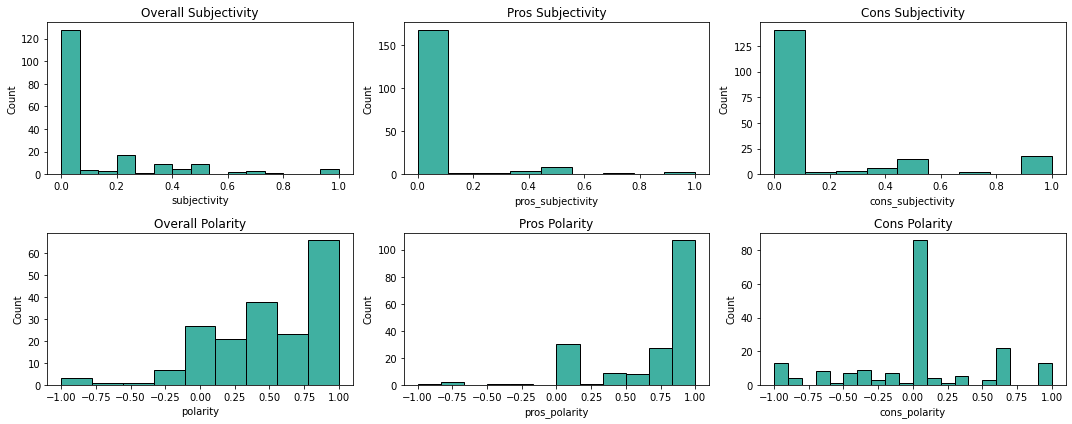

In [177]:
fig, ax = plt.subplots(2, 3, figsize=(15, 6))

# Plot histograms of subjectivity
sns.histplot(df['subjectivity'], color=color, edgecolor="black", ax=ax[0, 0])
ax[0, 0].set_title('Overall Subjectivity')
sns.histplot(df['pros_subjectivity'], color=color, edgecolor="black", ax=ax[0, 1])
ax[0, 1].set_title('Pros Subjectivity')
sns.histplot(df['cons_subjectivity'], color=color, edgecolor="black", ax=ax[0, 2])
ax[0, 2].set_title('Cons Subjectivity')

# Plot histograms of polarity
sns.histplot(df['polarity'], color=color, edgecolor="black", ax=ax[1, 0])
ax[1, 0].set_title('Overall Polarity')
sns.histplot(df['pros_polarity'], color=color, edgecolor="black", ax=ax[1, 1])
ax[1, 1].set_title('Pros Polarity')
sns.histplot(df['cons_polarity'], color=color, edgecolor="black", ax=ax[1, 2])
ax[1, 2].set_title('Cons Polarity')

# Tight layout
plt.tight_layout()

# Save the plot
#plt.savefig('plots/sentiment_histograms.png')

The first row of histograms represent the distribution of subjectivity for the overall text, pros, and cons respectively. Subjectivity quantifies the amount of personal opinion and factual information contained in the text. The values range between 0 and 1. The more subjective the text is, the closer to 1 the subjectivity score is.

The second row of histograms represent the distribution of polarity for the overall text, pros, and cons respectively. Polarity quantifies the sentiment of the text. The values range between -1 (most negative sentiment) and 1 (most positive sentiment).

Interpretation: Our analysis reveals that the vast majority of reviews are drafted with a significant degree of objectivity, as indicated by the low subjectivity scores. The exception is a small set of outliers. However, when examining the 'Cons' field specifically, we find a greater number of reviews that exhibit a higher degree of subjectivity. This suggests that employees expressing criticism about the company tend to have their perspectives significantly influenced by their emotions or personal beliefs, with these reviews often providing fewer objective facts.

The overall sentiment, or polarity, of the reviews reflects the rating distribution patterns we observed in the plots in chapter 3. Specifically, the majority of the reviews lean towards a positive sentiment, with a smaller proportion adopting a neutral stance and only a minimal percentage expressing a significantly negative view.

In the 'Pros' column, as expected, the majority of reviews convey a positive sentiment, in line with the intended purpose of this section for employees to share their positive experiences. There are, however, a few neutral sentiment reviews in this category, likely reflecting the perspective of those who assigned lower overall ratings and thus struggled to identify distinct positive aspects to highlight.

Turning our attention to the 'Cons' column, one might expect a predominance of negative sentiments, given the intended purpose of this section for employees to share their criticisms or areas of dissatisfaction. Interestingly, our analysis finds that many of the sentiments expressed in this section are neutral, with only a few positive and some negative.

This could indicate that employees who hold an overall positive view of the company (which, as our analysis revealed, forms the majority) might find it challenging to identify truly negative aspects to mention in their reviews. In some cases, they might even express positive sentiments in this section, despite the expectation that these would be confined to the 'Pros' field. Conversely, it's noteworthy that even negative ratings do not necessarily translate to highly negative sentiments; rather, these seem to reflect a more neutral perspective, suggesting that dissatisfaction, where present, is typically not extreme.

### Correlation Analysis

Let's also examine the correlation between the review length and the sentiment. Our hypothesis is that people who write a long review, probably want to get rid of their dissatisfaction and therefore write more than positive or neutral reviews. Since we are again working with the review length, we will use the filtered dataframe which has the outlier removed.

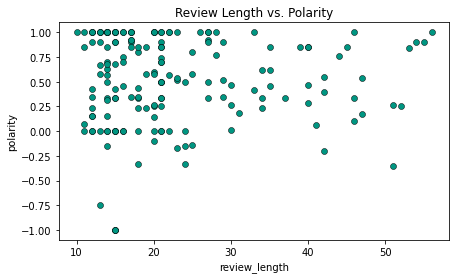

The correlation between review length and polarity is: 0.014538701239141352


In [178]:
df_filtered = df[(df['review_length'] >= lower_bound) & (df['review_length'] <= upper_bound)]
plt.figure(figsize=(7, 4))
sns.scatterplot(data=df_filtered, x='review_length', y='polarity', color = color, edgecolor="black")
plt.title('Review Length vs. Polarity')
plt.show()

# Compute correlation coefficient
correlation1 = df_filtered[['review_length', 'polarity']].corr()
print(f"The correlation between review length and polarity is: {correlation1.iloc[0, 1]}")

If our assumption would be right, we would see some kind of trend from the upper left corner to the lower right corner. However, this would refelct only a linear relationship which can obviously not be confirmed at this point. It looks like that there is not really a correlation between sentiment and the review length which is also supported by the very low correlation coefficient of 0.01. The correlation coefficient ranges from -1 to 1. A value close to 1 indicates a strong positive correlation, a value close to -1 indicates a strong negative correlation, and a value close to 0 indicates no linear correlation.

Next we are also interested in the correlation of the sentiment score and the rating. At best, there should be some relationship, as people with a better sentiment score should assign a higher rating and therefore both values correlate. Since we are dealing with the rating which represents a discrete and limited number, a scatter plot is not the best way to visualize this type of variable and we therefore choose a more appropriate visualization such as boxplots. 

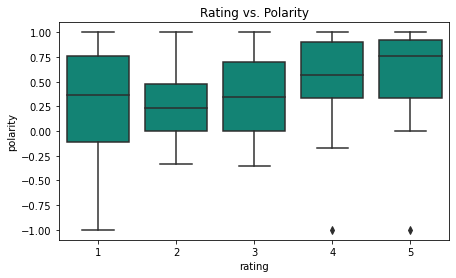

The correlation between rating and polarity is: 0.28925554030203915


In [179]:
# Scatter plot
plt.figure(figsize=(7, 4))
sns.boxplot(data=df, x='rating', y='polarity', color = color)
plt.title('Rating vs. Polarity')
plt.show()

# Compute correlation coefficient
correlation2 = df[['rating', 'polarity']].corr()
print(f"The correlation between rating and polarity is: {correlation2.iloc[0, 1]}")

In this case, we would expect a correlation coefficient close to 1, indicating a strong positive correlation. Even though the correlation is positive (indicating the obvious relation that the better the sentiment the higher the rating) and also quite high, but not perfect (i.e., exactly 1) due to various factors, such as the subjectivity of individual reviews or the possibility of a positive review having a lower rating and vice versa. However, looking at the boxplots we recognize a staircase development of the candles, supporting our assumption.

### Temporal Analysis

Next we could investigate the changes in sentiment over time to determine if certain events (like policy changes or certain company events) have impacted employee sentiment.

#### todo: Exponenzielle Glättung oder so drüber Legen, damit man eine Trendlinie erkennen kann!

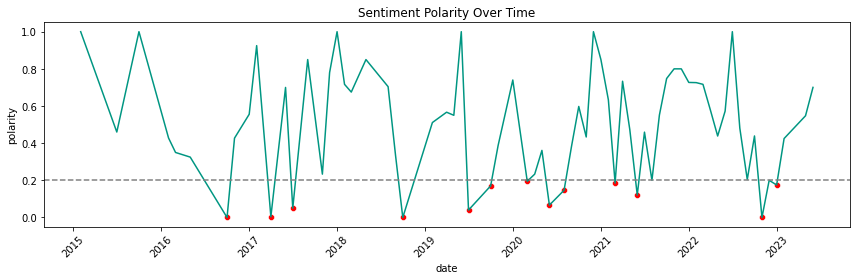

In [180]:
plt.figure(figsize=(12, 4))

# Resample the polarity to average it by month
df_resampled = df.copy()

# Make sure the date column is in datetime format
df_resampled['date'] = pd.to_datetime(df_resampled['date'])

# Set the date as the DataFrame index for easier plotting.
df_resampled.set_index('date', inplace=True)
df_resampled = df_resampled.resample('M').mean()

# Reset the index of the DataFrame
df_resampled.reset_index(inplace=True)

# Create line plot with Seaborn
sns.lineplot(x='date', y='polarity', data=df_resampled, color=color)

# Add a horizontal line at polarity = 0.2
plt.axhline(0.2, color='gray', linestyle='--')

# Highlight dates when the sentiment polarity was <= 0.2
low_sentiment_months = df_resampled[df_resampled['polarity'] <= 0.2]
sns.scatterplot(x='date', y='polarity', data=low_sentiment_months, color='red')

plt.title('Sentiment Polarity Over Time')
plt.xticks(rotation=45)  # To make x-axis labels more readable
plt.tight_layout()
plt.show()

We recognize that sentiment fluctuates considerably. We also highlighted the months where the sentiment falls below a certain threshold of 0.2 and highlighted them with red dots. We also print out those months and this information could be used to perform some subsequent and more detailed analysis of those months. When adding even further domain or expert knowledge from BASF employees, it might be possible to map those dates to specific business events and therefore gain even more insights into the company and what caused dissatisfaction.

However, it is remarkable that the average sentiment is in general pretty good, only fluctuating between 1 and 0, so between positive and neutral, but never turning into the negative range.

In [181]:
# Print dates when the sentiment polarity was <= 0.2
print('Months when sentiment was really low:')
print(low_sentiment_months['date'].dt.strftime('%Y-%m'))

Months when sentiment was really low:
20    2016-09
26    2017-03
29    2017-06
44    2018-09
53    2019-06
56    2019-09
61    2020-02
64    2020-05
66    2020-07
73    2021-02
76    2021-05
93    2022-10
95    2022-12
Name: date, dtype: object


In [182]:
# Extract 'date' column from 'low_sentiment_months' DataFrame, convert to period 'M'
low_sentiment_periods = low_sentiment_months['date'].dt.to_period('M')
reviews_count = df[df['date'].dt.to_period('M').isin(low_sentiment_periods)].groupby(df['date'].dt.to_period('M')).size()

# Create a dataframe from the series
reviews_count_df = reviews_count.reset_index()
reviews_count_df.columns = ['Month', 'Review Count']

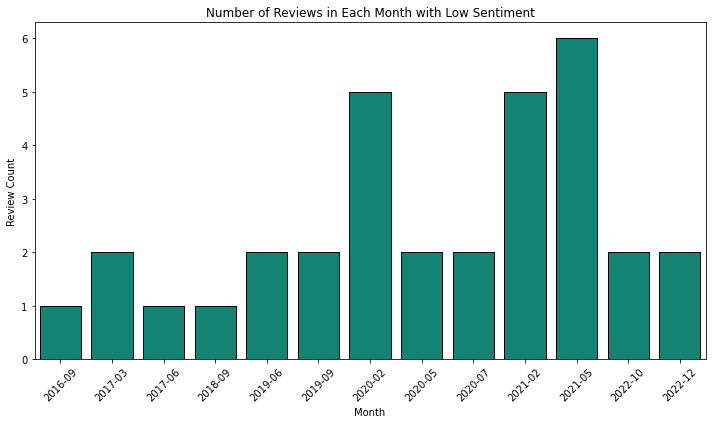

In [183]:
# Create bar plot
plt.figure(figsize=(10, 6))

sns.barplot(x='Month', y='Review Count', data=reviews_count_df, color=color, edgecolor='black')

plt.title('Number of Reviews in Each Month with Low Sentiment')
plt.xlabel('Month')
plt.ylabel('Review Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

When we have a look at the specific months with a low sentiment score and the amount of reviews that have been submitted in this time period, we can clearly see that a lot of these deep downward swings were caused by only a few reviews and therefore may not be truly representative. When inspecting the specific months even more in detail, it becomes obvious that we can not really derive any meaningful results due to the lack of data.

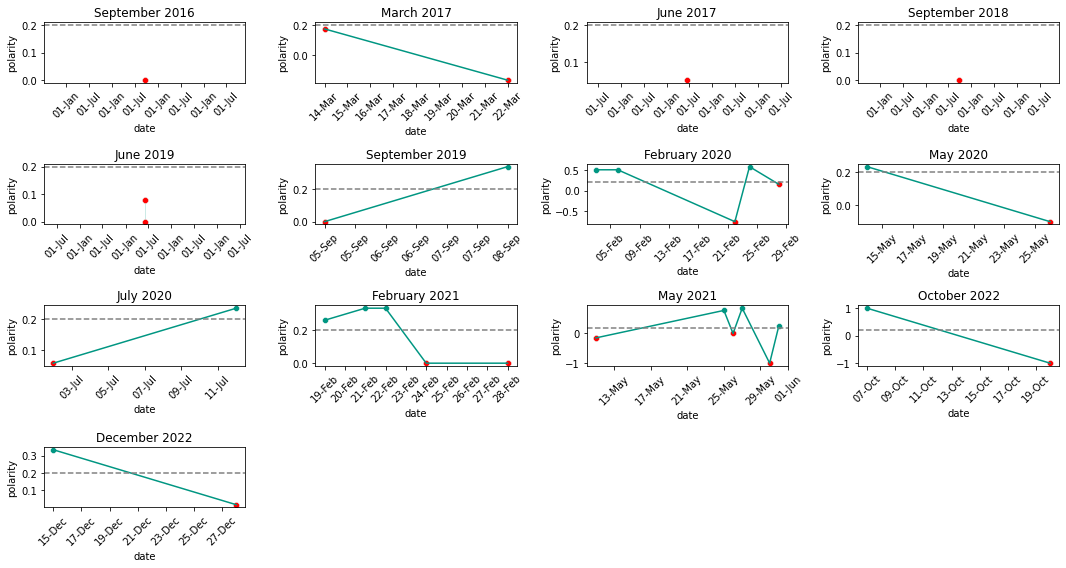

In [184]:
# Dates when the sentiment polarity was <= 0.2
low_sentiment_months = df_resampled[df_resampled['polarity'] <= 0.2]['date'].dt.to_period('M')

# Calculate the required grid size
num_months = len(low_sentiment_months)
grid_rows = math.ceil(num_months / 4)  # 4 plots per row

# Prepare a grid for the subplots
fig, axes = plt.subplots(grid_rows, 4, figsize=(15, grid_rows * 2))

# Flatten the 2D array to 1D for easier iteration
axes = axes.flatten()

# Iterate over each month
for i, month in enumerate(low_sentiment_months):
    # Filter data for the specific month
    month_data = df[(df['date'].dt.year == month.year) & (df['date'].dt.month == month.month)]
    
    # Create a scatter plot for the specific month showing all sentiments
    all_sentiment_days = month_data
    sns.scatterplot(ax=axes[i], x='date', y='polarity', data=all_sentiment_days, color=color)
    
    # Create a line plot for the specific month
    sns.lineplot(ax=axes[i], x='date', y='polarity', data=month_data, color=color)

    # Set the title of the subplot to the month and year
    axes[i].set_title(f"{calendar.month_name[month.month]} {month.year}")

    # Highlight days where sentiment falls below 0.2
    low_sentiment_days = month_data[month_data['polarity'] <= 0.2]
    sns.scatterplot(ax=axes[i], x='date', y='polarity', data=low_sentiment_days, color='red')

    # Mark the 0.2 line
    axes[i].axhline(0.2, color='gray', linestyle='--')

    # Improve the x-axis date format
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45)

# Remove any empty plots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [185]:
# Saving the completely edited dataframe for usage in our dashboard
df.to_csv('./data/processed_data.csv', index=False)

## 10. Conclusion

In conclusion, your project on "Analysis for Job Reviews" has successfully leveraged a wide range of data analysis techniques and methodologies to extract valuable insights from job reviews. The project began with data loading, cleaning, and text preprocessing, which set a solid foundation for the subsequent analyses.

Through exploratory data analysis, you were able to understand the distribution of ratings, review lengths, and their correlation, as well as the temporal trends in job ratings and review counts. This provided a comprehensive overview of the data at hand.

The use of IF-IDF, Lasso Regression and Topic Modeling further deepened your understanding of the data, helping you identify the terms that drive ratings and the major concerns of employees. This is particularly valuable for the company as it provides clear areas of focus for improvement. The creation of word clouds based on tf-idf values for pros and cons, job clustering, and sentiment analysis further enriched the analysis by providing visual and categorical insights into the data.

The project also incorporated elements of Generative AI, with the implementation of an automated response and advicing system using GPT-3. This system not only responds to employee feedback but also generates actionable advice based on the pain points mentioned by the employees. This is a significant achievement as it demonstrates the potential of AI in facilitating effective communication and problem-solving within a company.

Finally, the project culminated in the development of a comprehensive dashboard using [Streamlit](https://streamlit.io/). This dashboard effectively presents the key findings of the project in an interactive and user-friendly manner, making the insights easily accessible to stakeholders. We therefore created a new python file which is named 'dashboard.py'. To open the dashboard on our local browser, you have to open a terminal and direct to the path where the 'dashboard.py' file is located. Then you can type 'streamlit run dashboard.py' and a new browser window with the application will launch and open. Then you are ready to play around with it! Also remember that you need a linked OpenAI subscription to be able to use the 'Automated Response System' which is connected to GPT-3 via OpenAI-API.

Overall, your project has successfully demonstrated the power of data analysis and AI in extracting valuable insights from job reviews. Even though we don't have enough data for truly robust results, this project is intended to illustrate the possibilities and potential for companies that work with and analyze existing job ratings. It provides a robust framework for understanding employee feedback and offers actionable solutions for improvement. This project is not only academically rigorous but also has significant practical implications for enhancing organizational performance and employee satisfaction.